# 0.0. Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import datetime
import yapf
import xgboost as xgb


from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from scipy                 import stats  as ss
from boruta                import BorutaPy
# from datetime              import datetime, date, time, timedelta

## 0.1. Helper Functions

In [108]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame(
        {
            'Model Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        },
        index=[0])


def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))




def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()
    
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(
            days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(
            days=(k - 1) * 6 * 7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date)
                                & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation),
                             np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        print(lr_result)

    return pd.DataFrame(
        {
            'model name': model,
            'MAE CV':
            np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' +
            np.round(np.std(mae_list), 2).astype(str),
            'MAPE CV':
            np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' +
            np.round(np.std(mape_list), 2).astype(str),
            'RMSE CV':
            np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' +
            np.round(np.std(rmse_list), 2).astype(str)
        },
        index=[0])

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data


In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. Passo 01 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()


## 1.1. Rename Columns

In [5]:
cols_old = [
    'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
    'CompetitionDistance', 'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
    'PromoInterval'
]

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename

df1.columns = cols_new

## 1.2. Data Dimension

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(
    lambda x: x['date'].month
    if math.isnan(x['competition_open_since_month']) else x[
        'competition_open_since_month'],
    axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x[
        'competition_open_since_year']) else x['competition_open_since_year'],
    axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].week
    if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],
    axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year
    if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],
    axis=1)

# promo_interval
month_map = {
    1: 'Jan',
    2: 'Fev',
    3: 'Mar',
    4: 'Apr',
    5: 'Mai',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1
    if x['month_map'] in x['promo_interval'].split(',') else 0,
    axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types


In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1[
    'competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(
    include=['int64', 'float64', 'datetime64[ns]'])

In [15]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
8670,866,5,6748,457,1,0,0,9680.0,7,2015,1,5,2013,0
66902,3,1,11594,1012,1,1,0,14130.0,12,2006,1,14,2011,0


In [16]:
cat_attributes.sample(2)

,store,day_of_week,date,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
650471,97,1,2013-11-25,6249,683,1,0,0,8980.0,11,2013,0,48,2013,0
972971,362,6,2013-02-09,9239,1155,1,0,0,340.0,2,2013,0,6,2013,0


## 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, range kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = [
    'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew',
    'kurtosis'
]

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


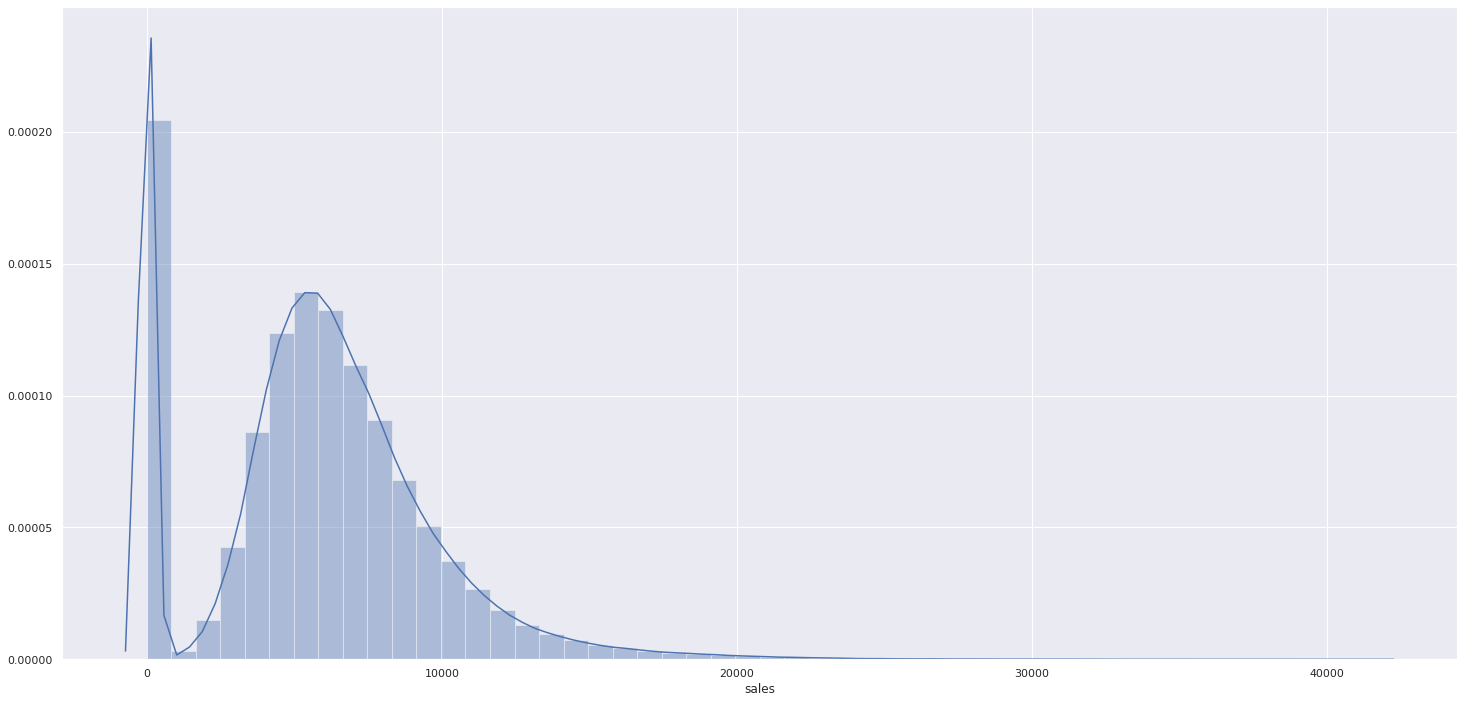

In [19]:
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

store                            1115
day_of_week                         7
date                              942
sales                           21734
customers                        4086
open                                2
promo                               2
school_holiday                      2
competition_distance              655
competition_open_since_month       12
competition_open_since_year        23
promo2                              2
promo2_since_week                  52
promo2_since_year                   7
is_promo                            2
dtype: int64

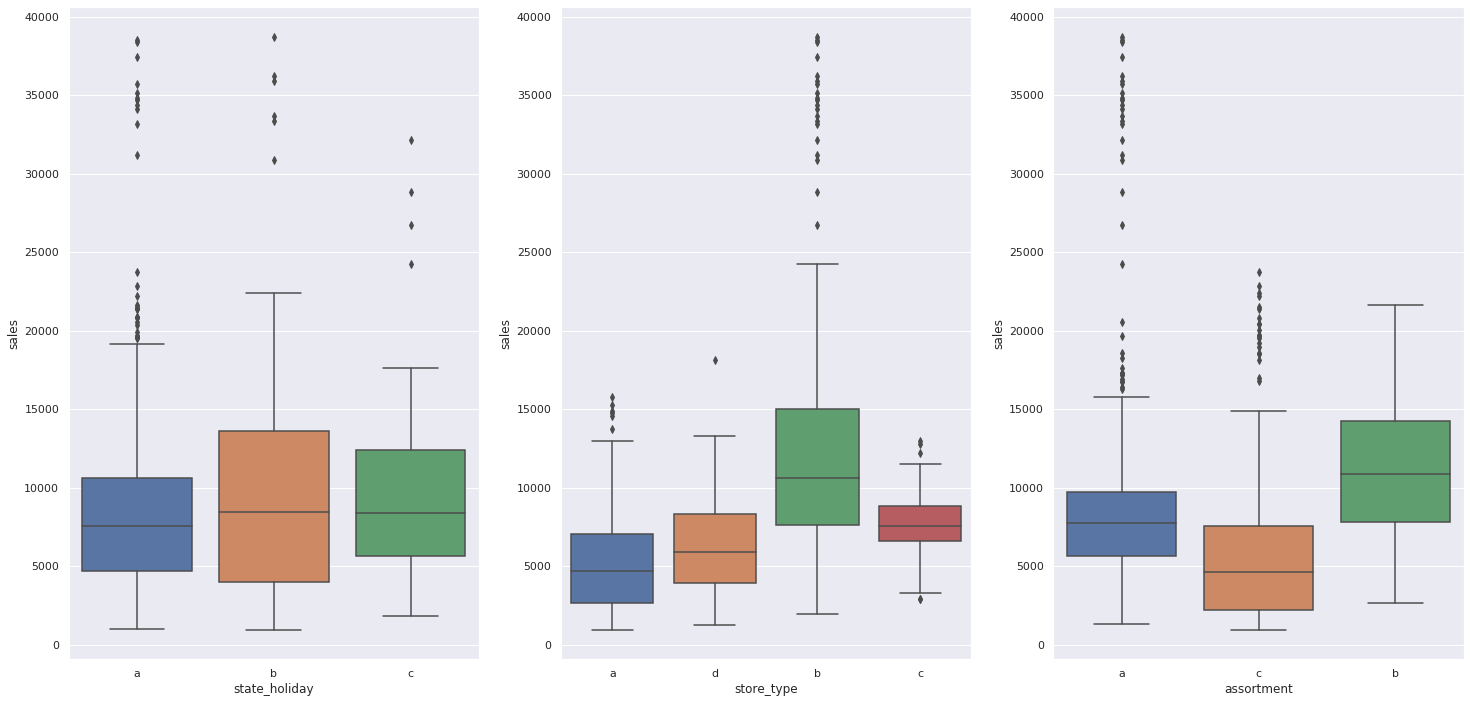

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. Passo 02 - FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## Mapa Mental de Hipóteses

In [23]:
Image('img/MindMapHypothesis.png')

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

<IPython.core.display.Image object>

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo deveriam vender mais

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoem mais os produtos nas vitrines deveriam vender mais

**3.** Lojas que tem preços menores deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais

**7.** Lojas com  mais dias de promoções deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3 Hipóteses Tempo (Sazonalidade)

**1.** Lojas abertas durante o friado de natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo do ano

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos fins de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com  mais dias de promoções deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o friado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo do ano

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos fins de semana

**12.** Lojas deveriam vender menos durante os feriados escolares


## 2.3 Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                month=x['competition_open_since_month'],
                                day=1),
    axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /
                                 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'
                                         ) - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /
                          7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday'
    if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. Passo 03 - FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção de Colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Passo 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [29]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1. Response Variable

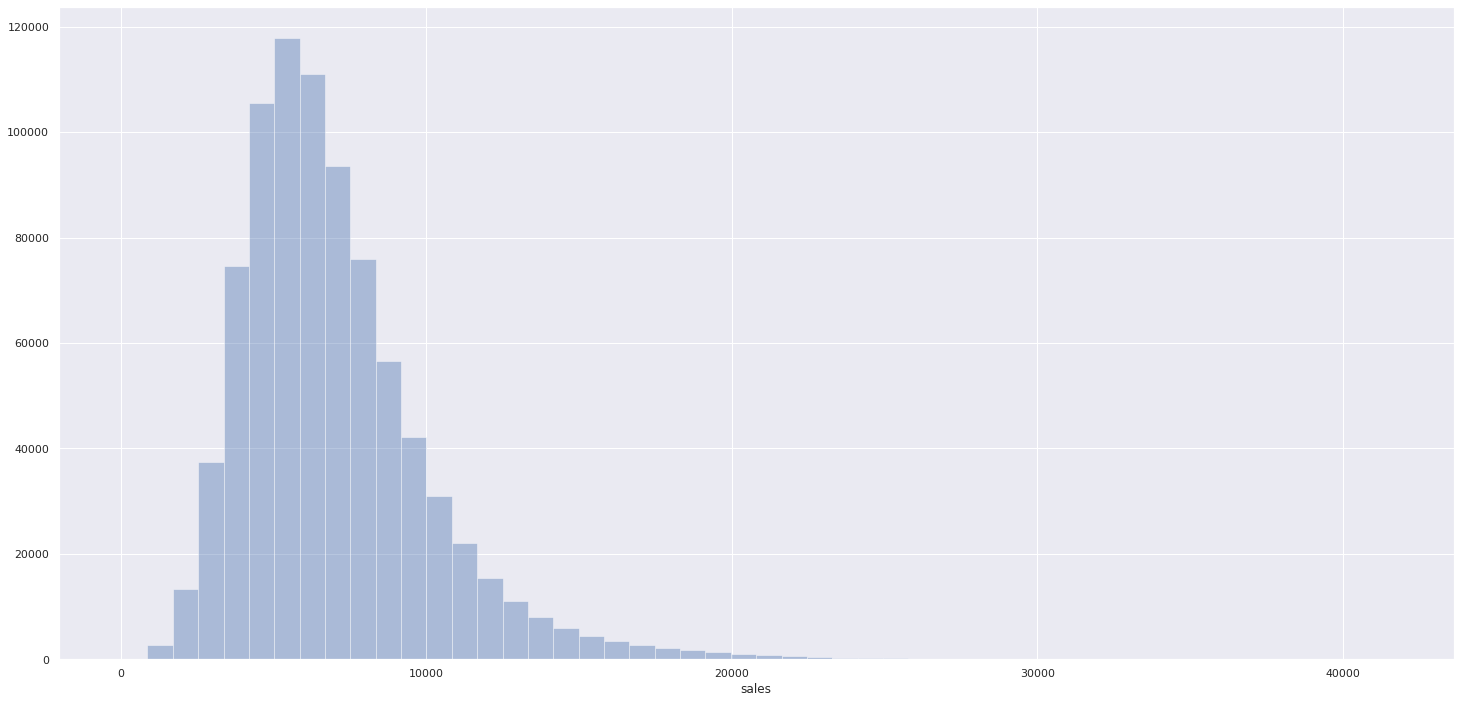

In [30]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2. Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc033deeb80>,
      dtype=object)

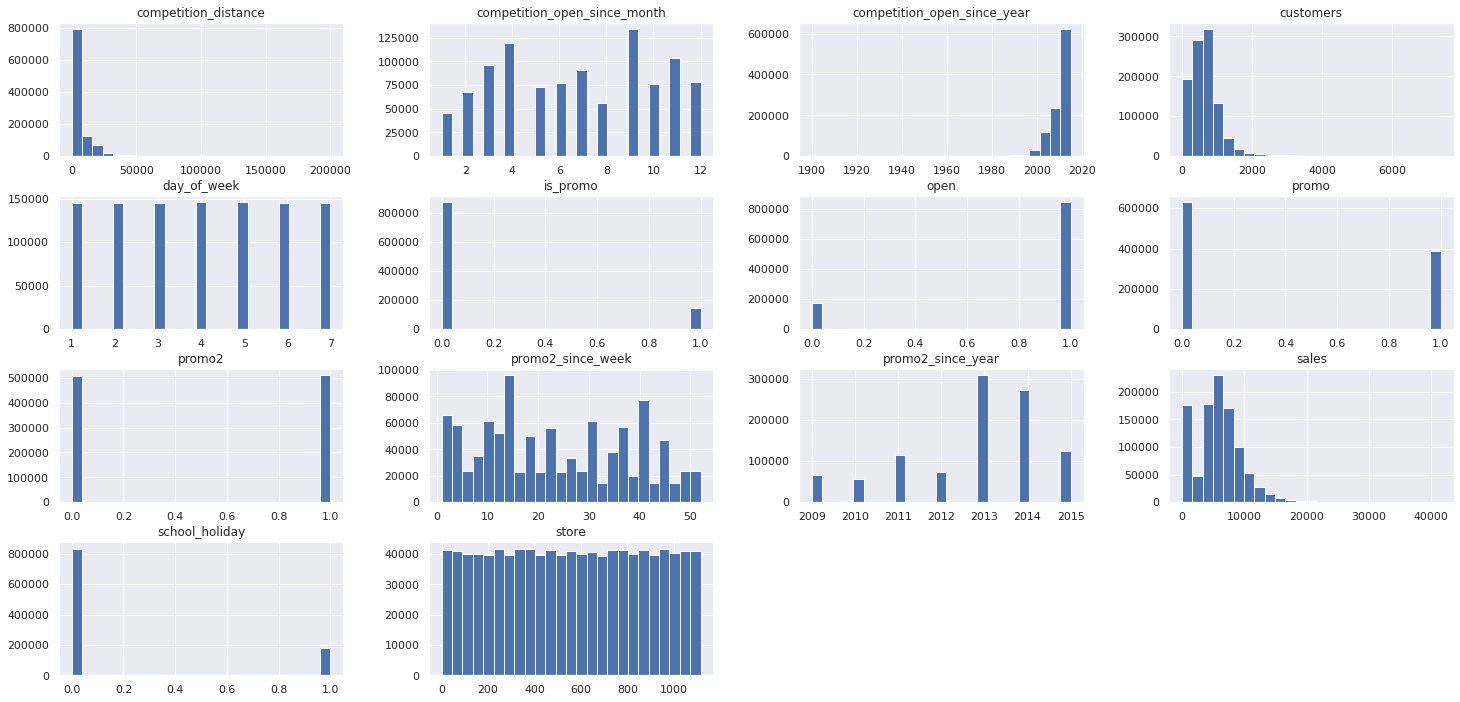

In [31]:
num_attributes.hist(bins=25)

### 4.1.3. Categorical Variable

In [32]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

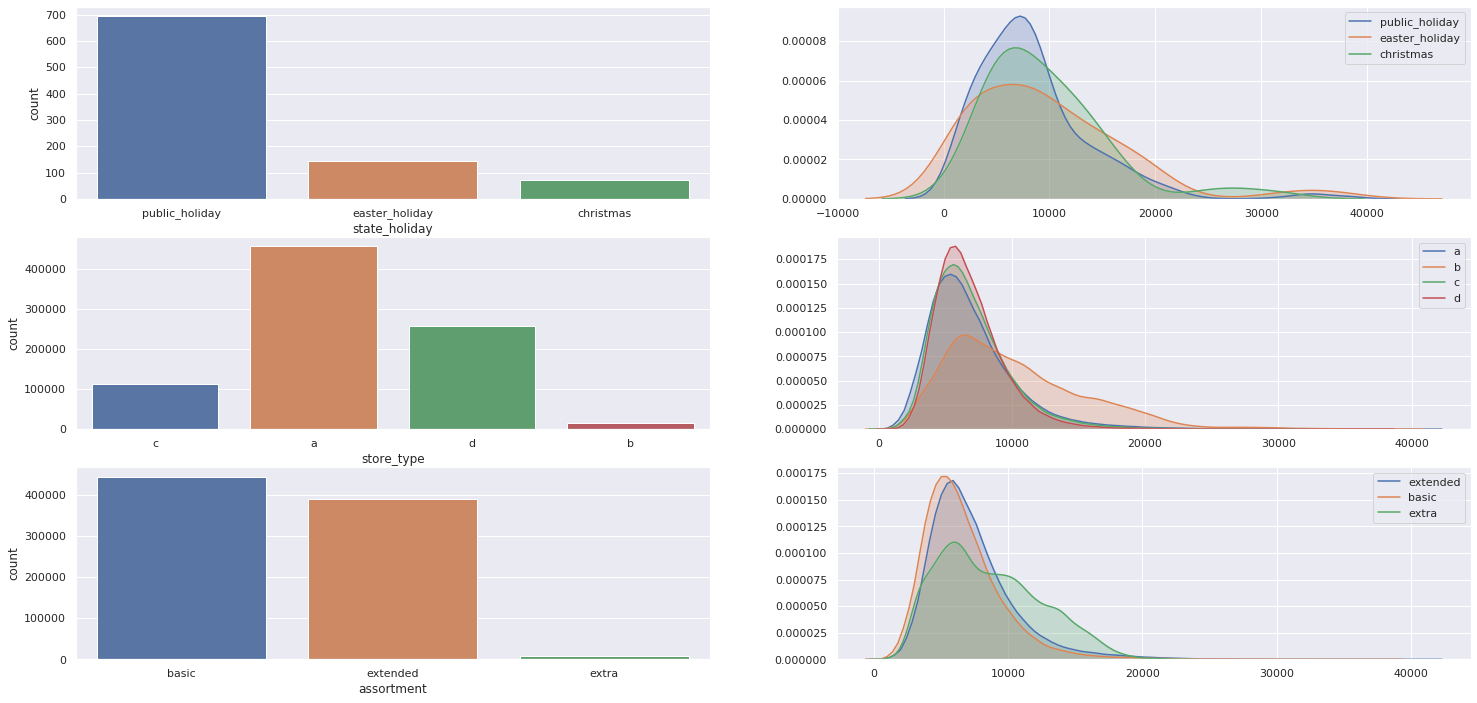

In [33]:
# state holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],
            label='public_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
            label='easter_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],
            label='christmas',
            shade=True)
plt.legend(labels=["public_holiday", "easter_holiday", "christmas"])

# store type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend(labels=["a", "b", "c", "d"])

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
            label='extended',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
            label='basic',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
            label='extra',
            shade=True)
plt.legend(labels=["extended", "basic", "extra"])

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS









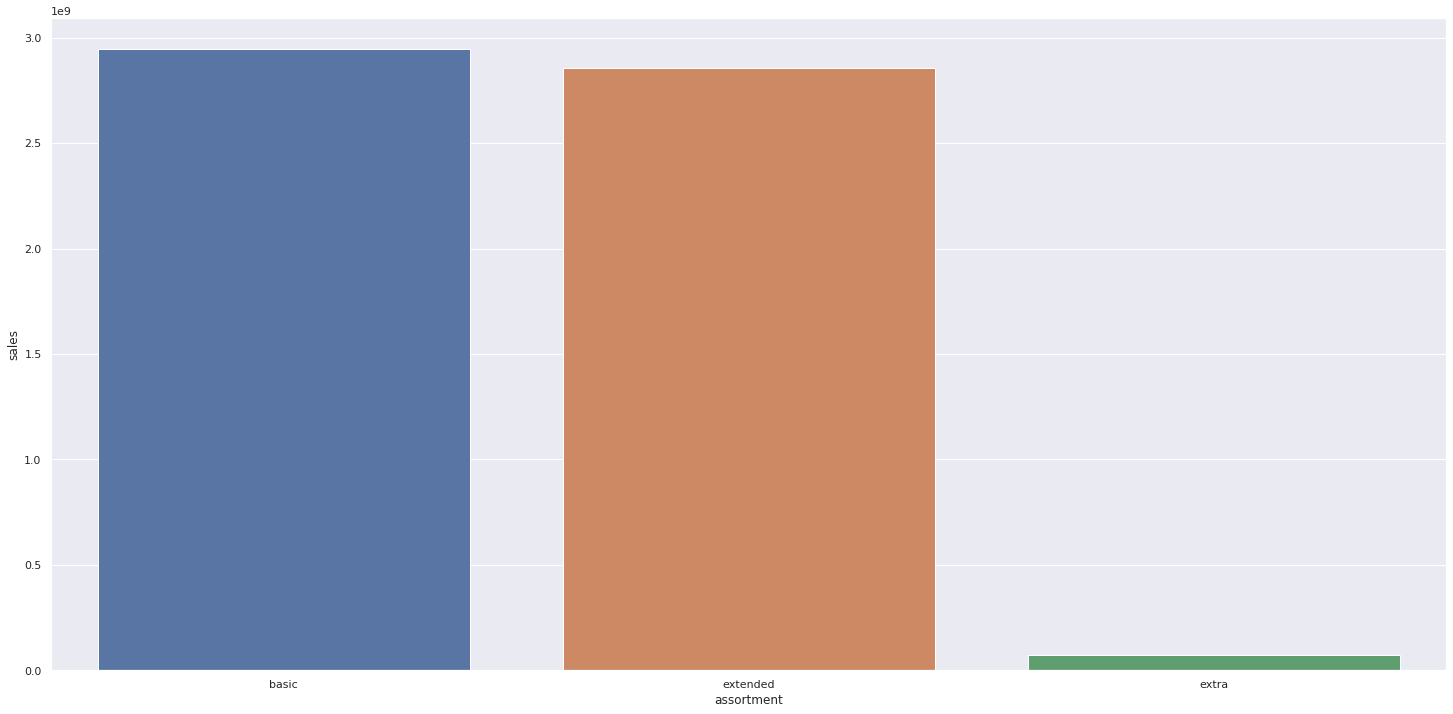

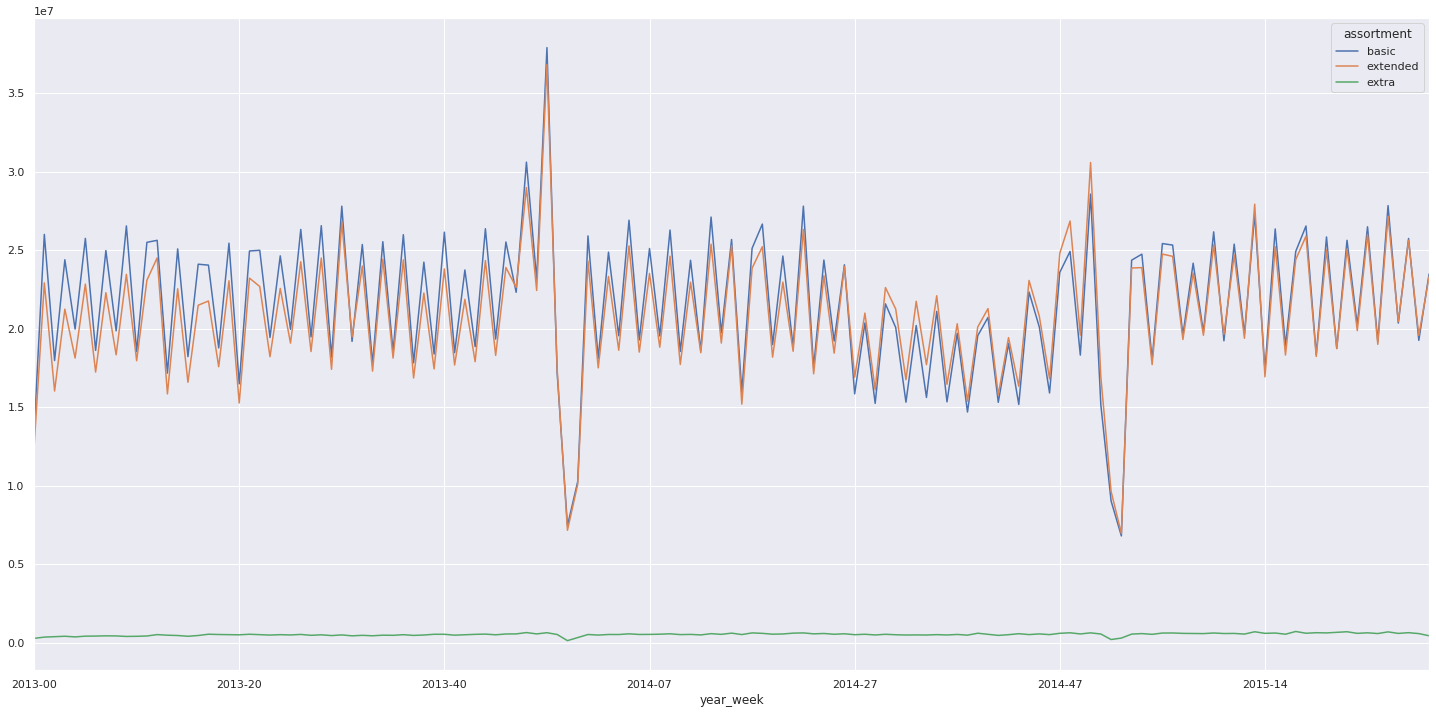

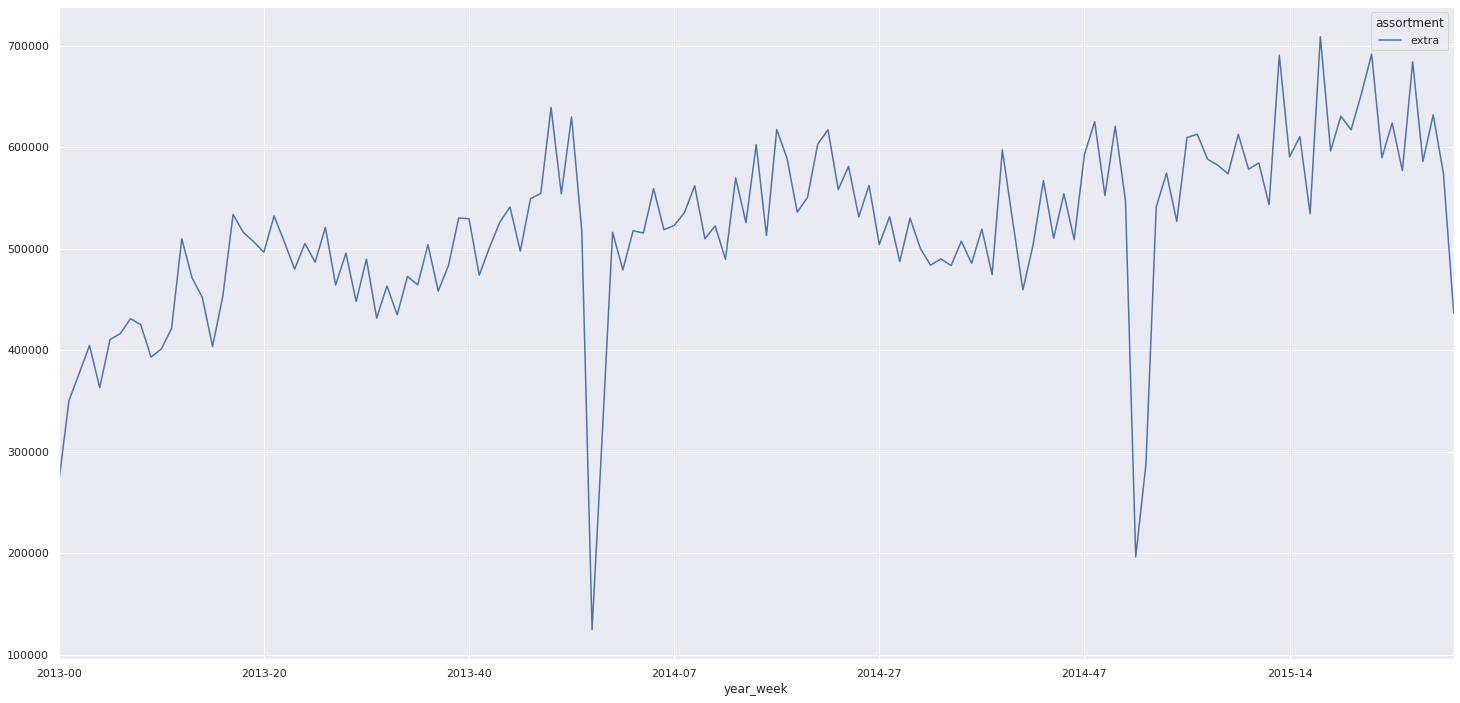

In [34]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment',
            'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS


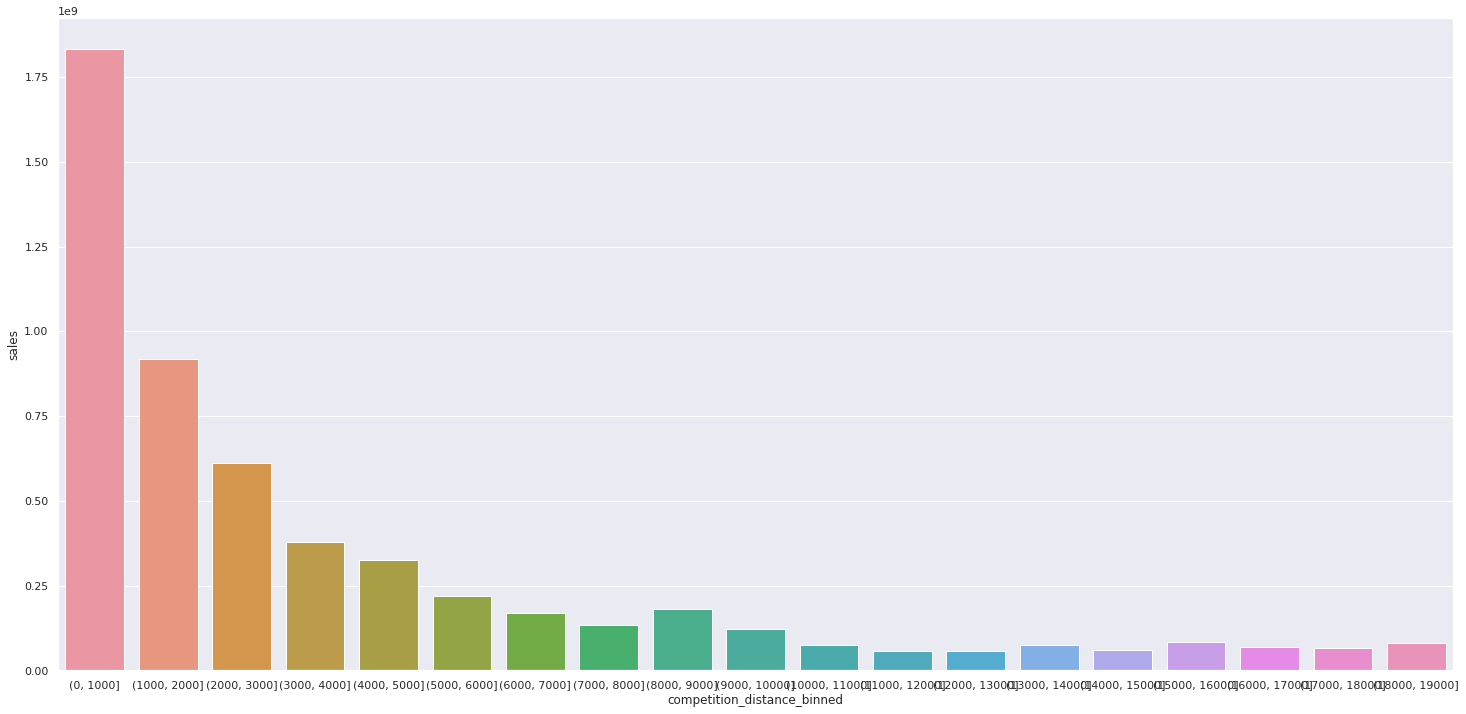

In [35]:
aux1 = df4[['competition_distance',
            'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],
                                             bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales'
             ]].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

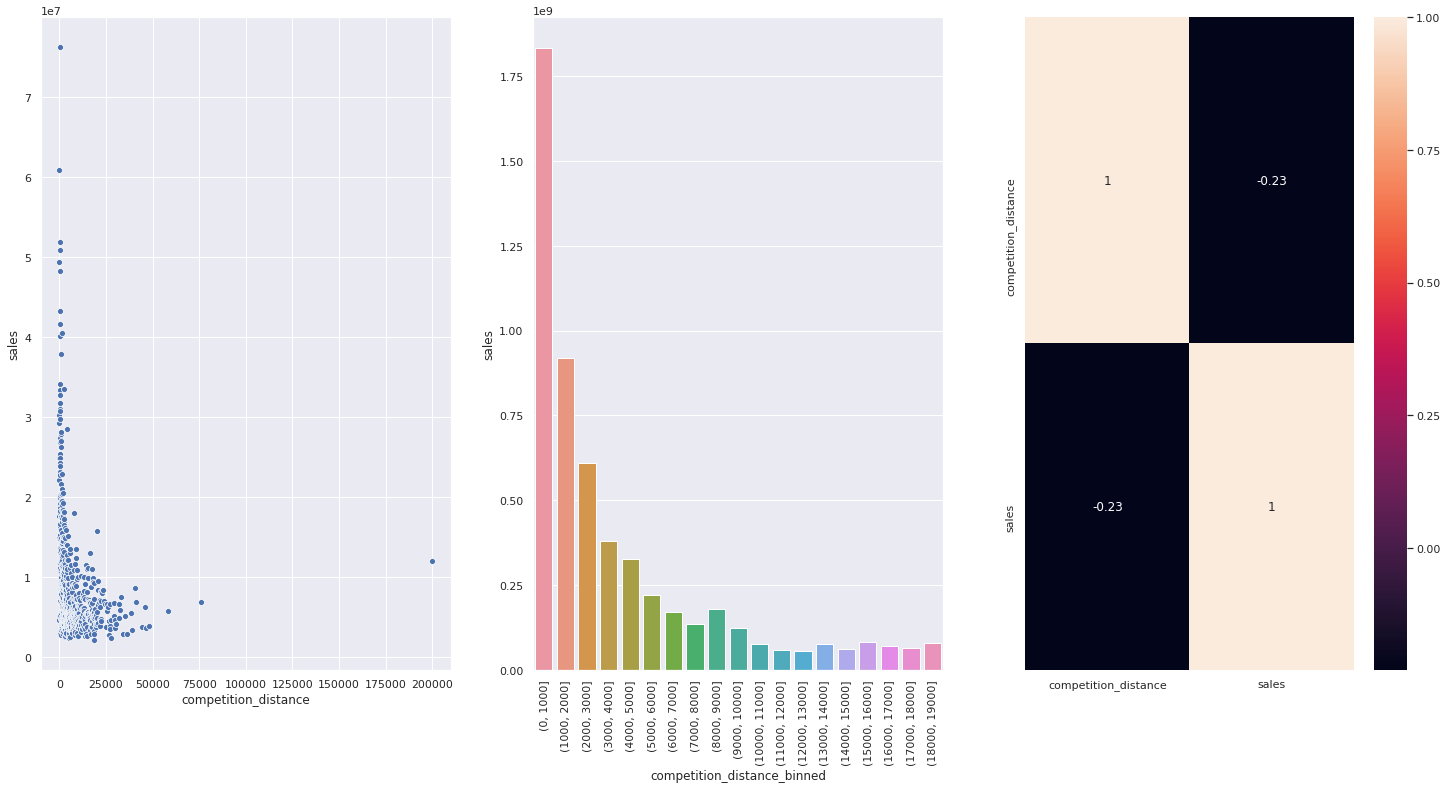

In [36]:
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],
                                             bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales'
             ]].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vender mais
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS


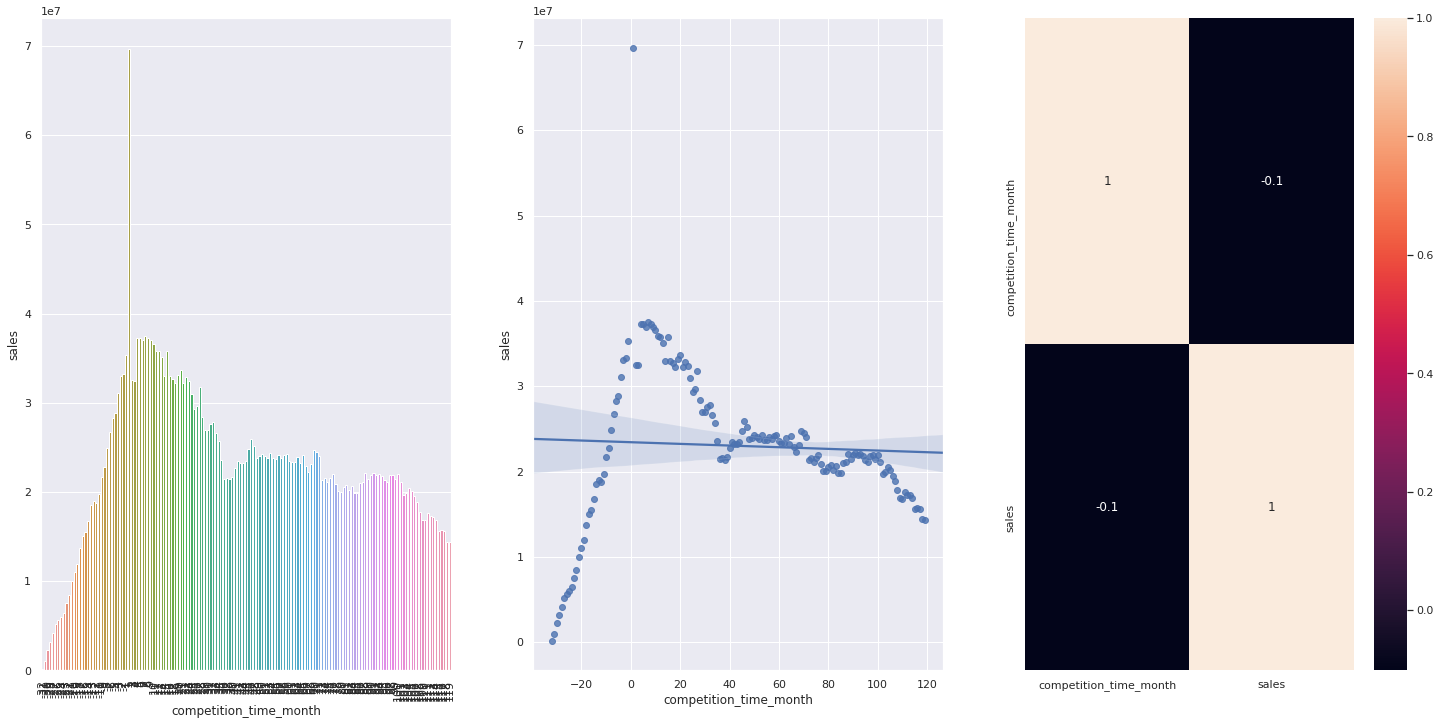

In [37]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month',
            'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120)
            & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais


**Falsa**  Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

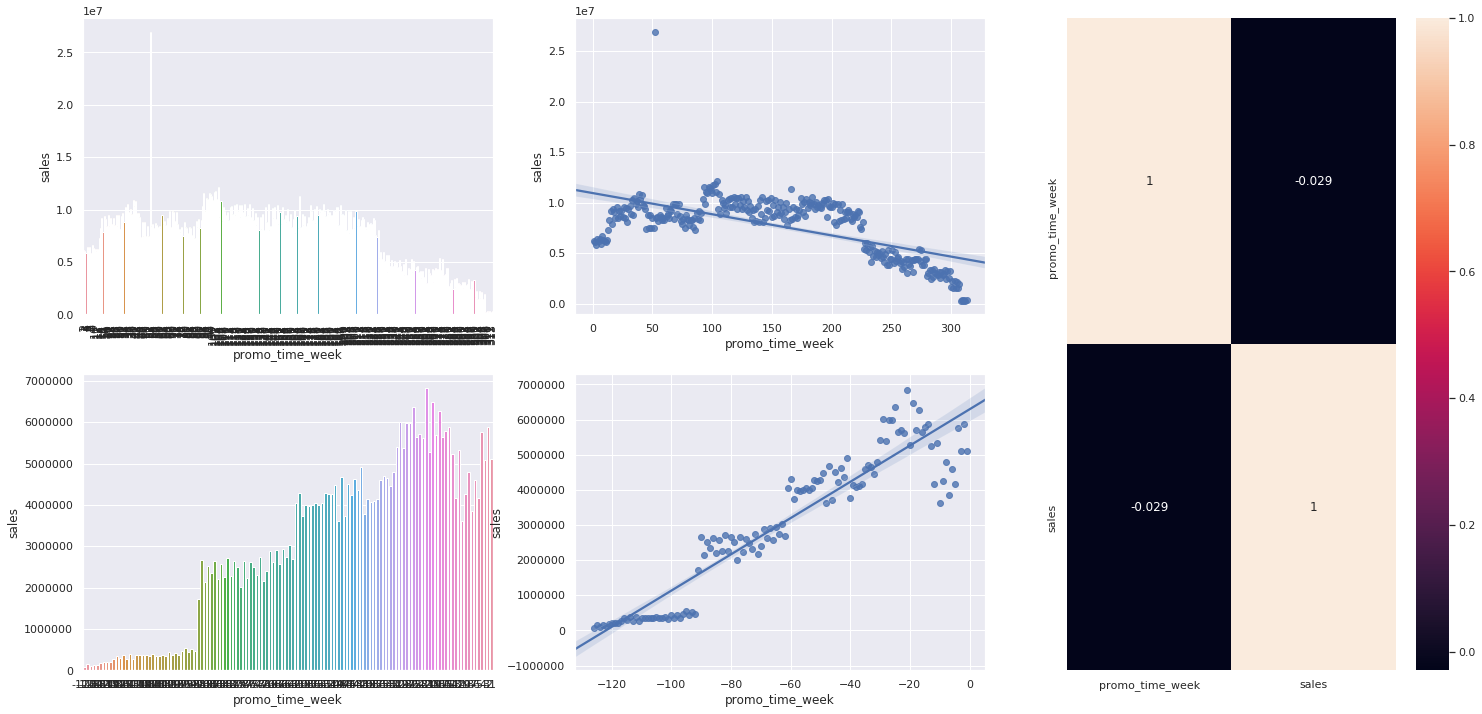

In [38]:
aux1 = df4[['promo_time_week',
            'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week', y='sales', data=aux1)

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # Período Extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # Período Extendido
sns.barplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr('pearson'), annot = True)

### <s> H5. Lojas com  mais dias de promoções deveriam vender mais </s>


### H6. Lojas com promoções mais consecutivas vendem mais
**Falsa**  com promoções mais consecutivas vendem menos

In [39]:
df4[['promo', 'promo2', 'sales']].groupby(['promo',
                                           'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


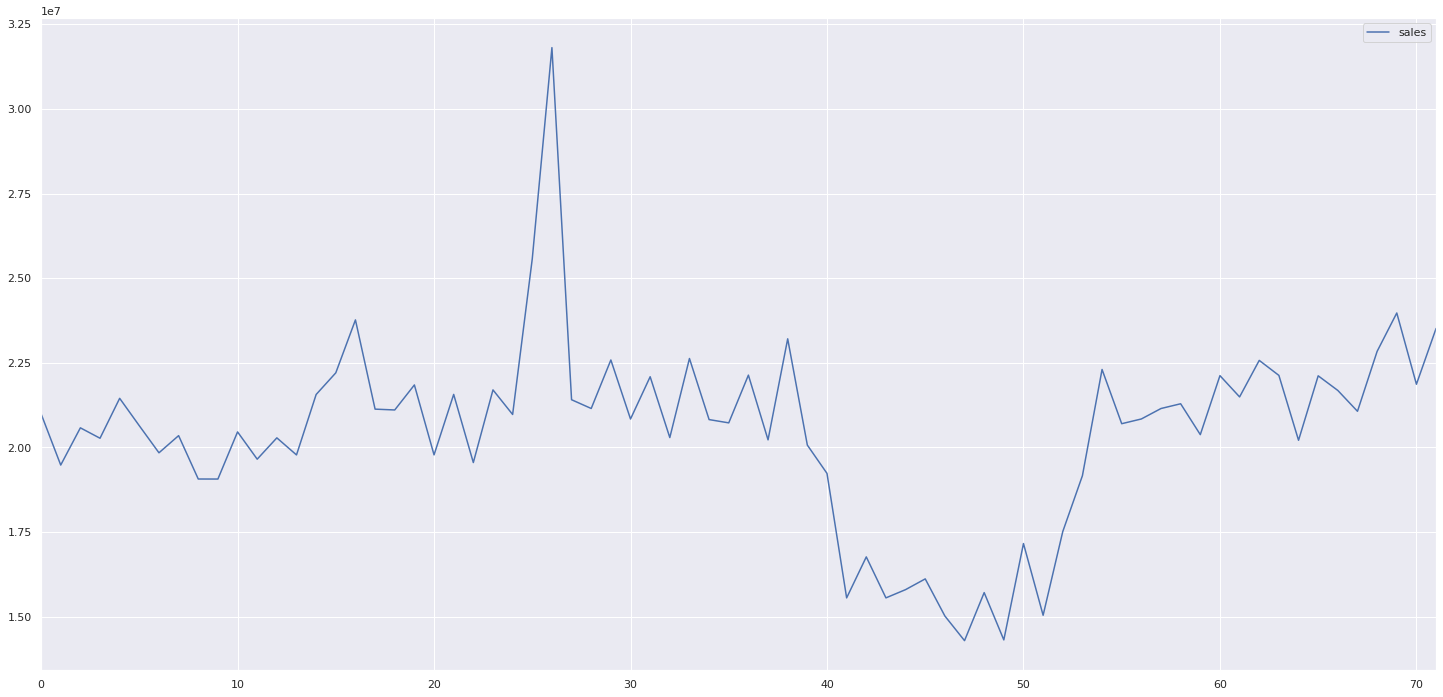

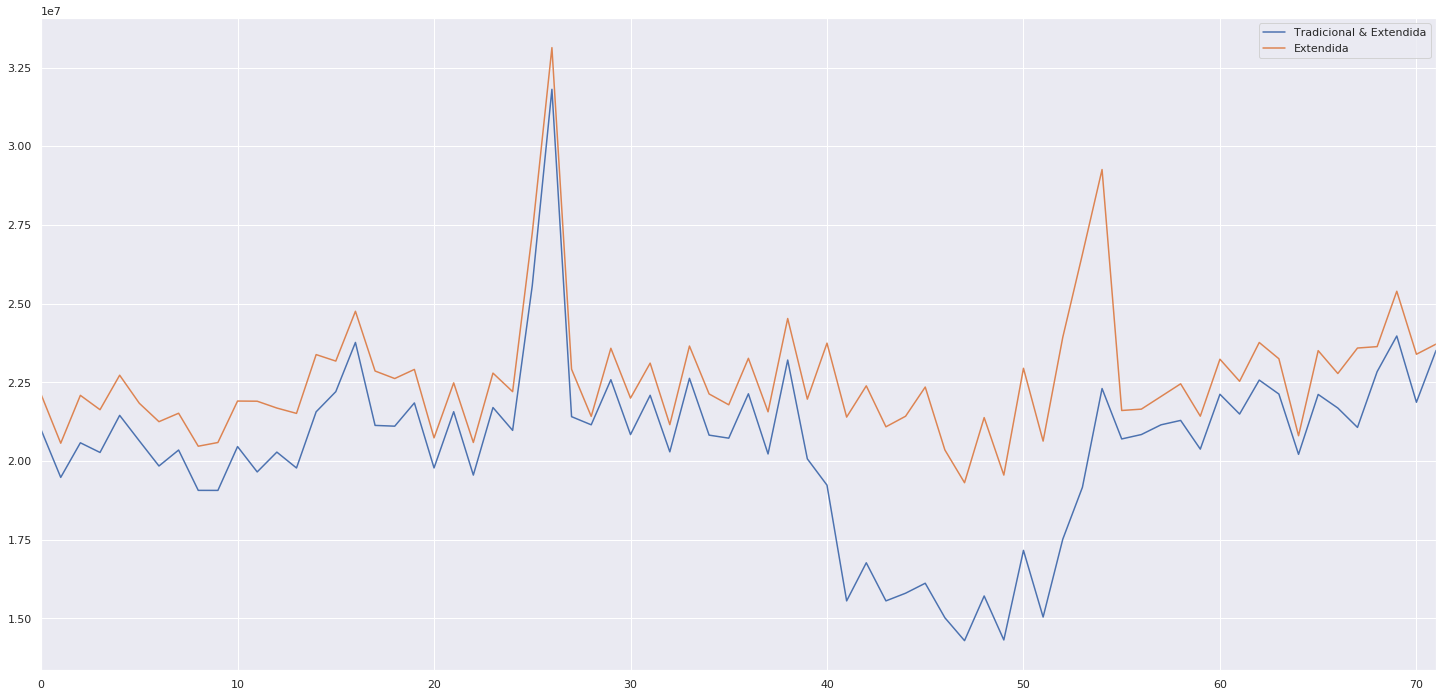

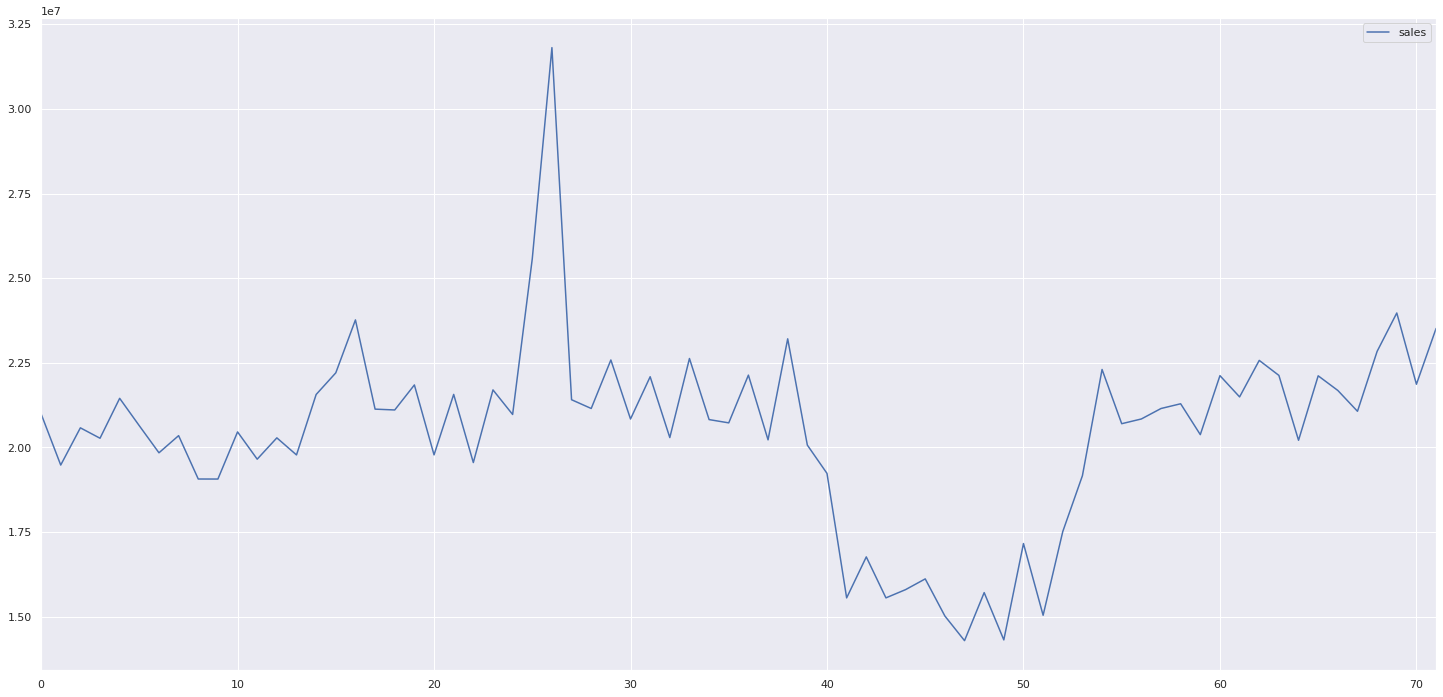

In [40]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
aux1.plot()

ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
aux1.plot()

aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

### H7. Lojas abertas durante o friado de natal deveriam vender mais
**Falsa** Lojas abertas durante o friado de natal vendem menos

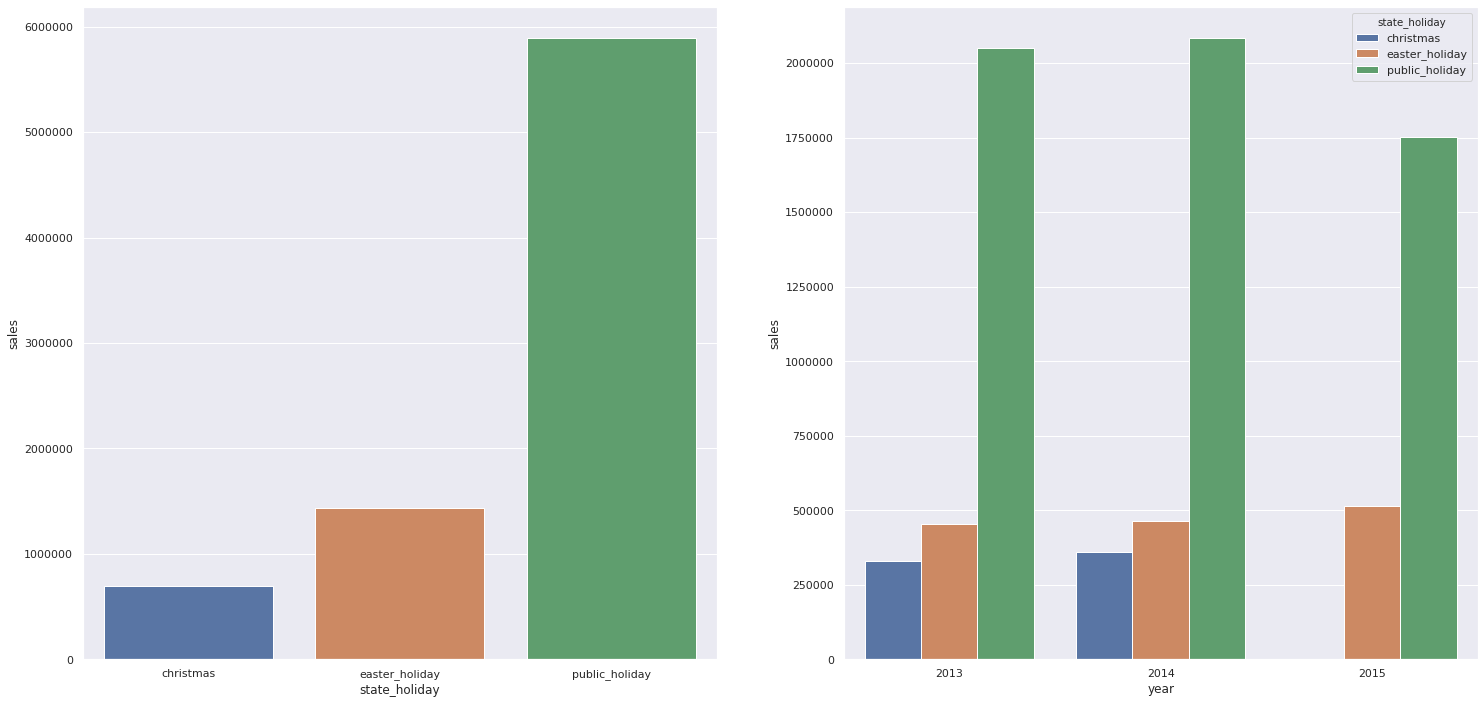

In [41]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday',
            'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday',
            'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue = 'state_holiday', data=aux2)

### H8. Lojas deveriam vender mais ao longo do ano
**Falsa**  As Lojas vendem menos ao longo do ano

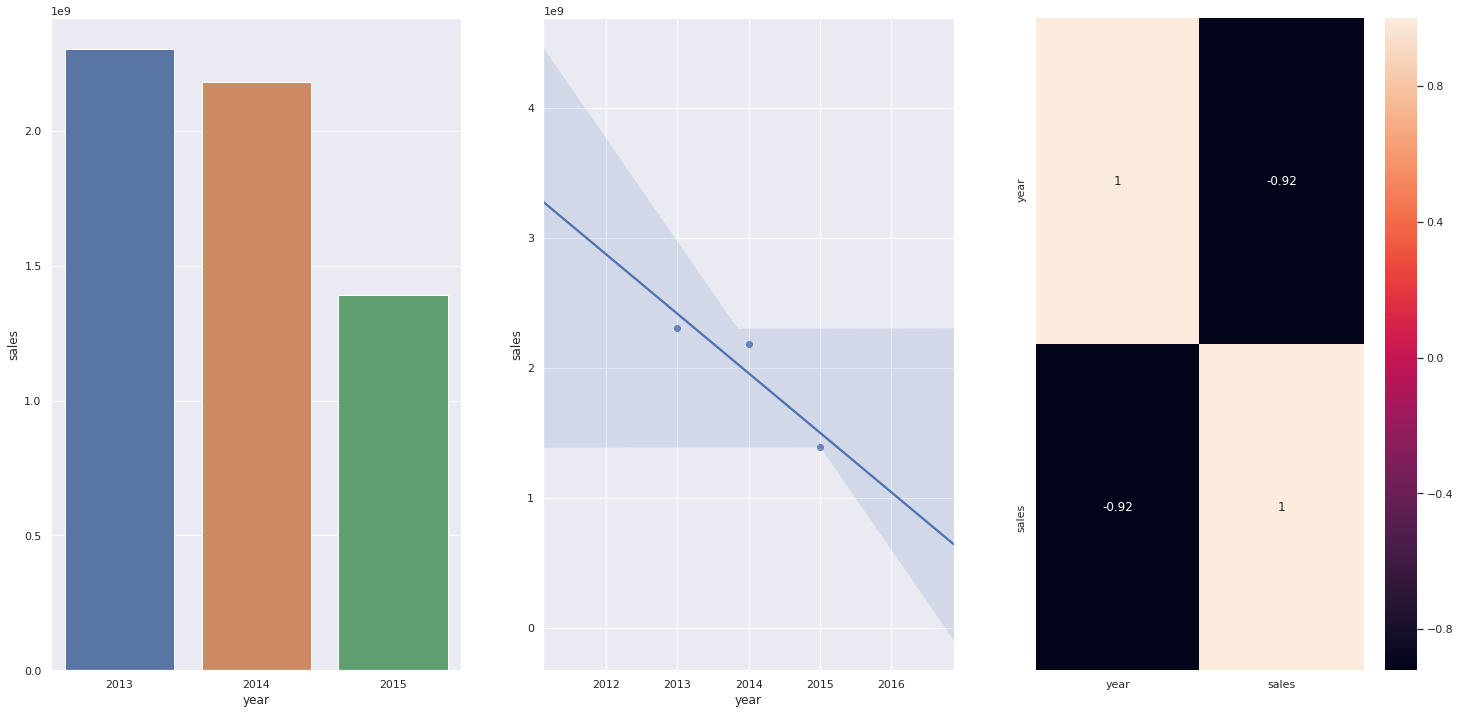

In [42]:
plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H9. Lojas deveriam vender mais no segundo semestre do ano
**Falsa**  As Lojas vendem menos no segundo semestre do ano

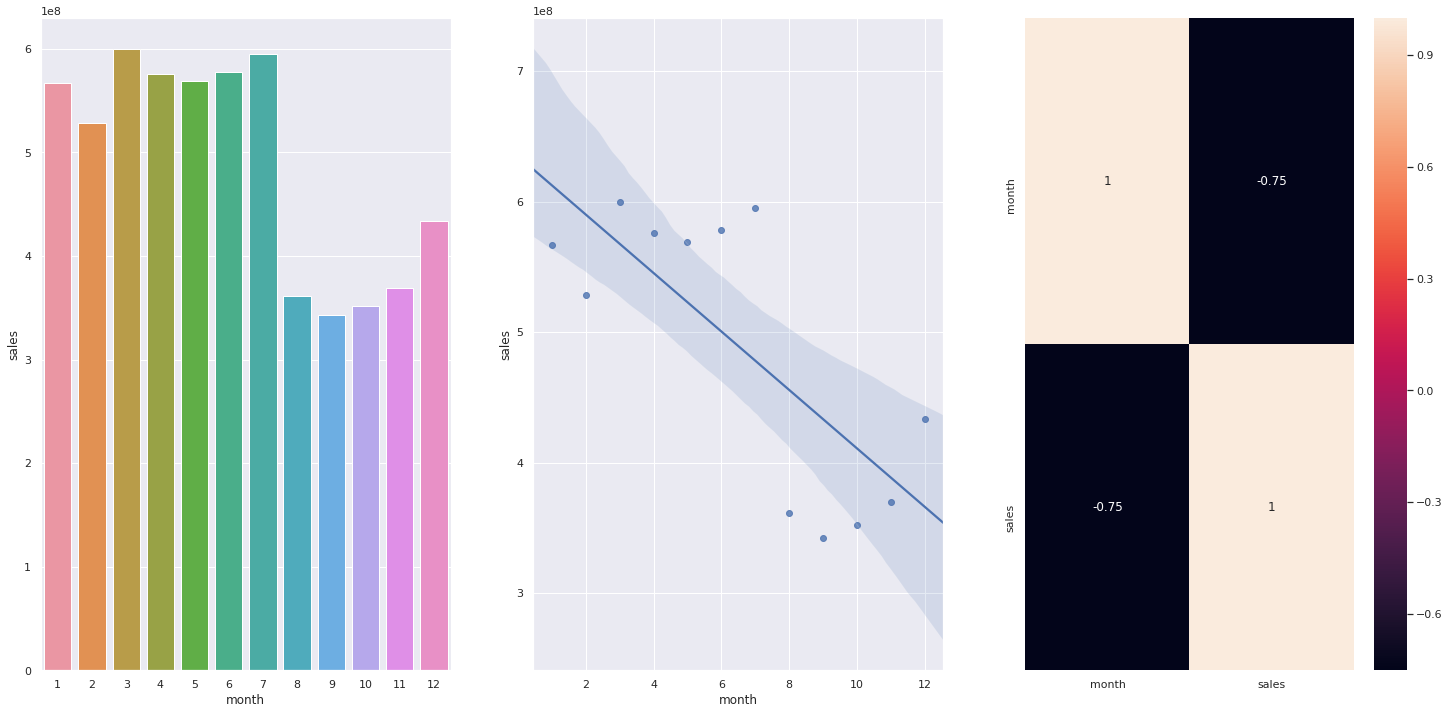

In [43]:
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês
**Verdadeira** Lojas vendem mais depois do dia 10 de cada mês

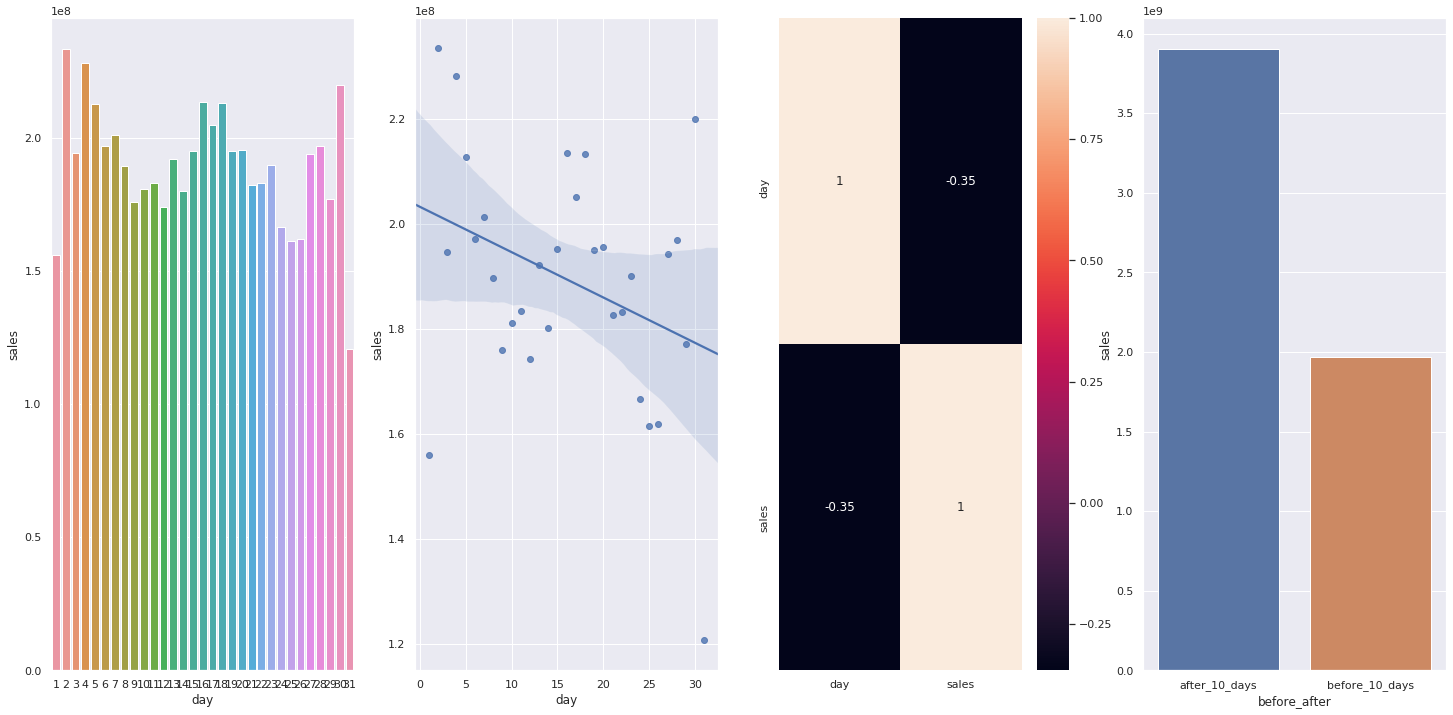

In [44]:
plt.subplot(1, 4, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(1, 4, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(1, 4, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days'
                                         if x <= 10 else 'after_10_days')

plt.subplot(1, 4, 4)
aux2 = aux1[['before_after',
             'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2)

### H11. Lojas deveriam vender menos aos fins de semana
**Verdadeira** Lojas vendem menos nos finais de semana


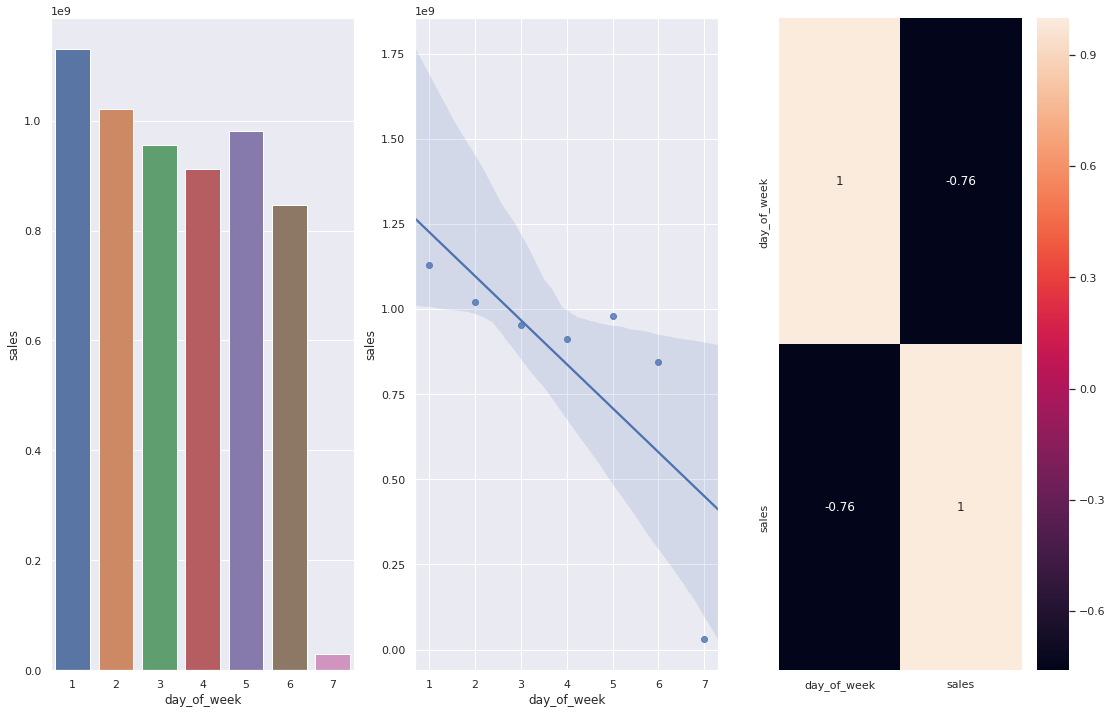

In [45]:
plt.subplot(1, 4, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 4, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 4, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H12. Lojas deveriam vender menos durante os feriados escolares
**Verdadeira** Lojas vendem menos durante os feriados escolares

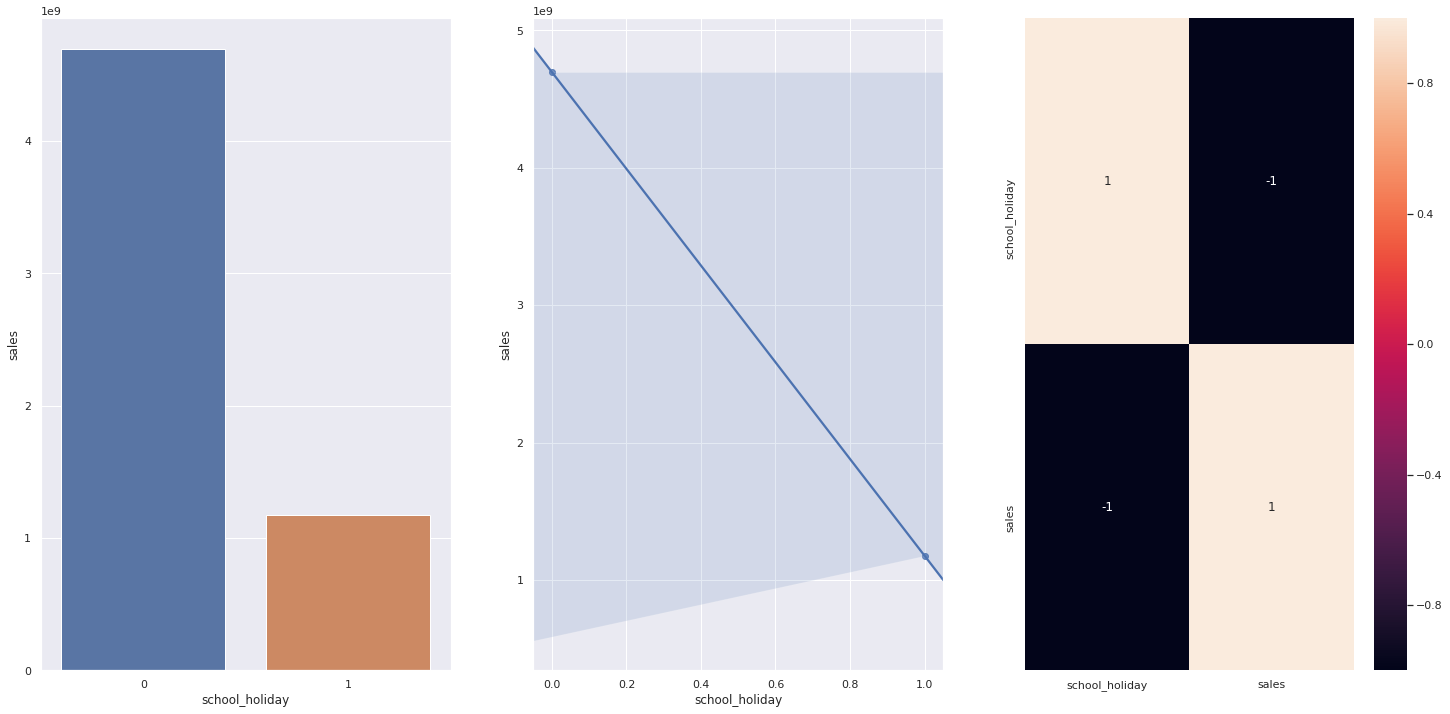

In [46]:
plt.subplot(1, 3, 1)
aux1 = df4[['school_holiday',
            'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


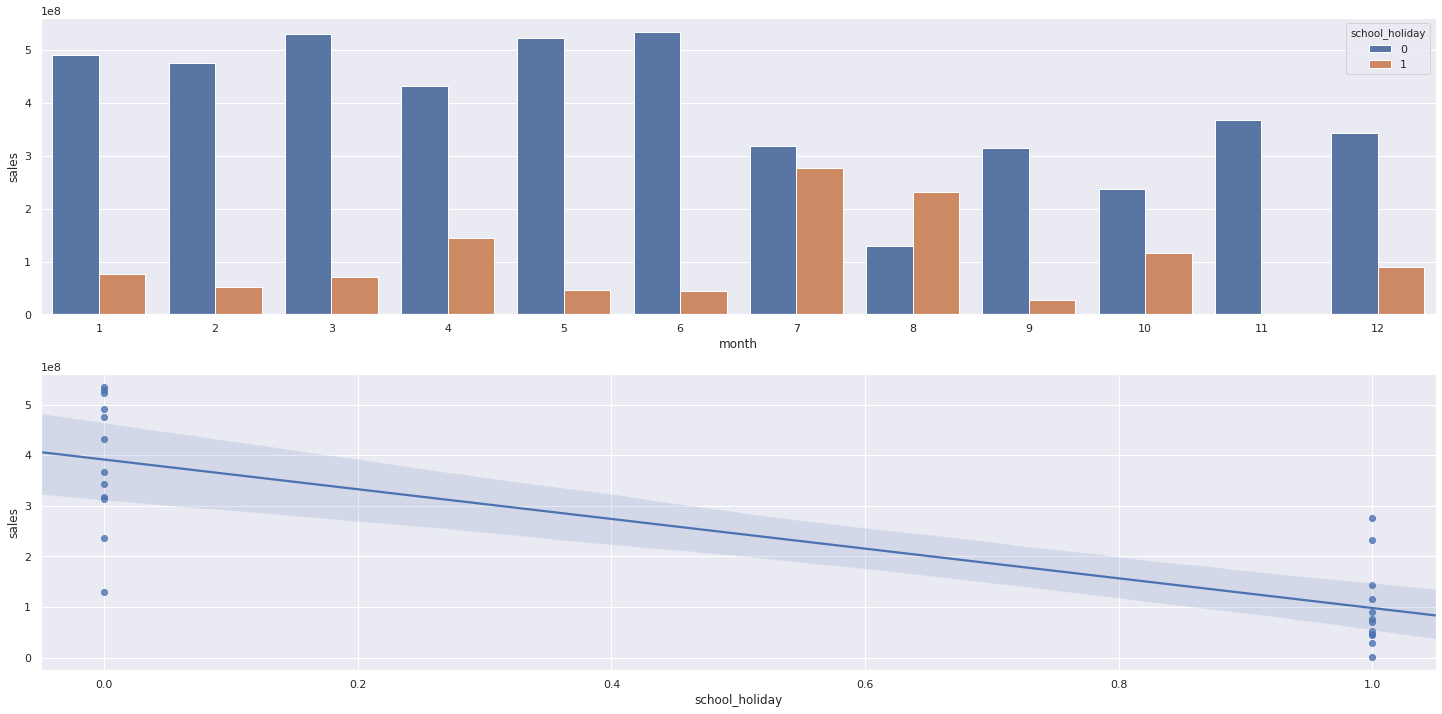

In [47]:
plt.subplot(2, 1, 1)
aux1 = df4[['month','school_holiday',
            'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1)

plt.subplot(2, 1, 2)
sns.regplot(x='school_holiday', y='sales', data=aux1)


### 4.2.1 Resumo das Hipóteses

In [48]:
from tabulate import tabulate

In [49]:
tab = [
    ['Hipótese', 'Conclusão', 'Relevância'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Média'],
    ['H3', 'Falsa', 'Média'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Média'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa'],
]

In [50]:
print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1. Numerical Attributes

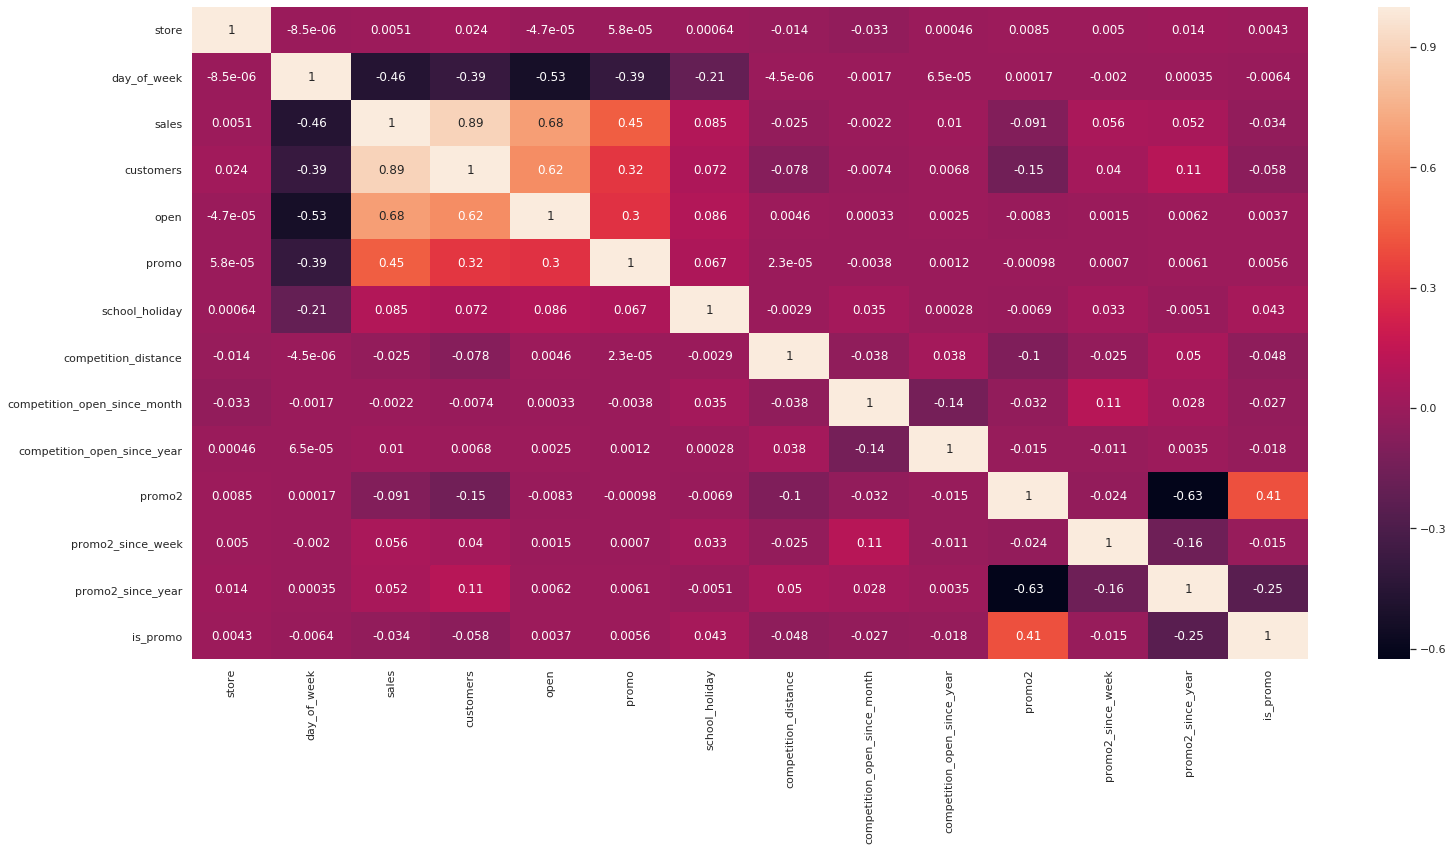

In [51]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attributes

<ipython-input-2-72615eb5bcd5>:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(x, y).as_matrix()


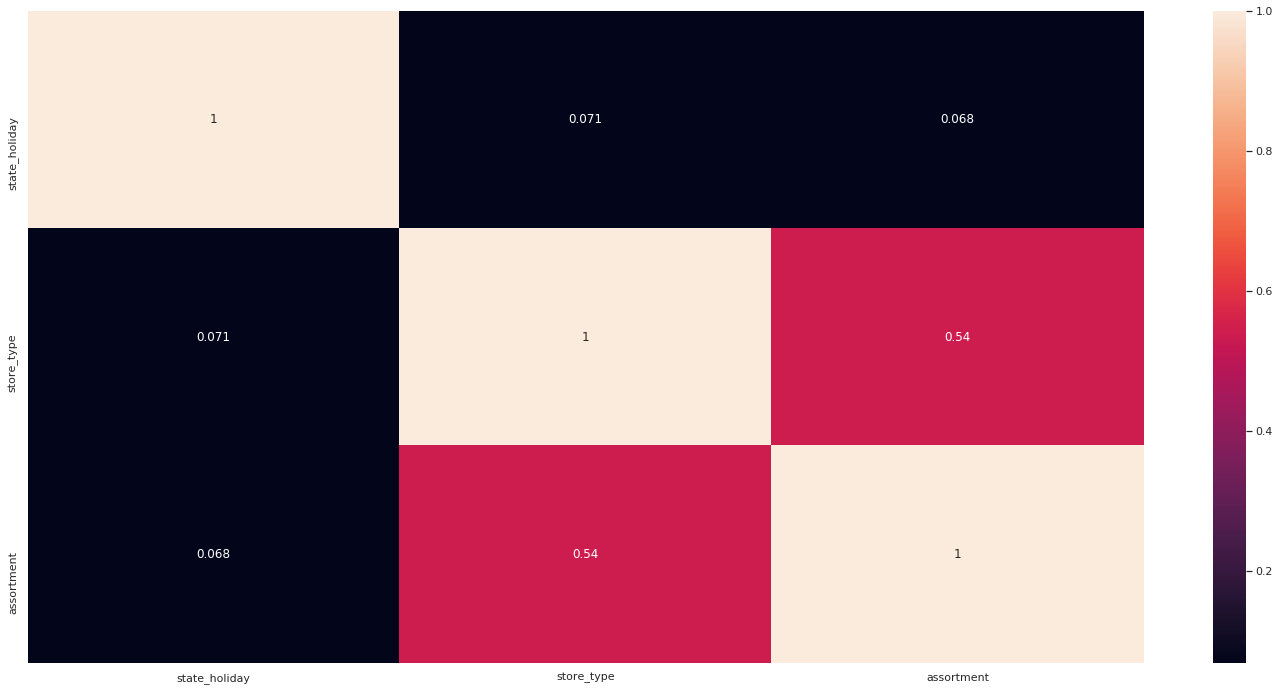

In [52]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]
})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0. Passo 05 - PREPARAÇÃO DOS DADOS

In [53]:
df5 = df4.copy()

## 5.1. Normalização
Não haverá normalização de variáveis pois não temos nehuma variável numérica da análise exploratória de dados com distribuição normal

## 5.2. Rescaling

In [54]:
a = df5.select_dtypes(include = ['int64', 'float64'])

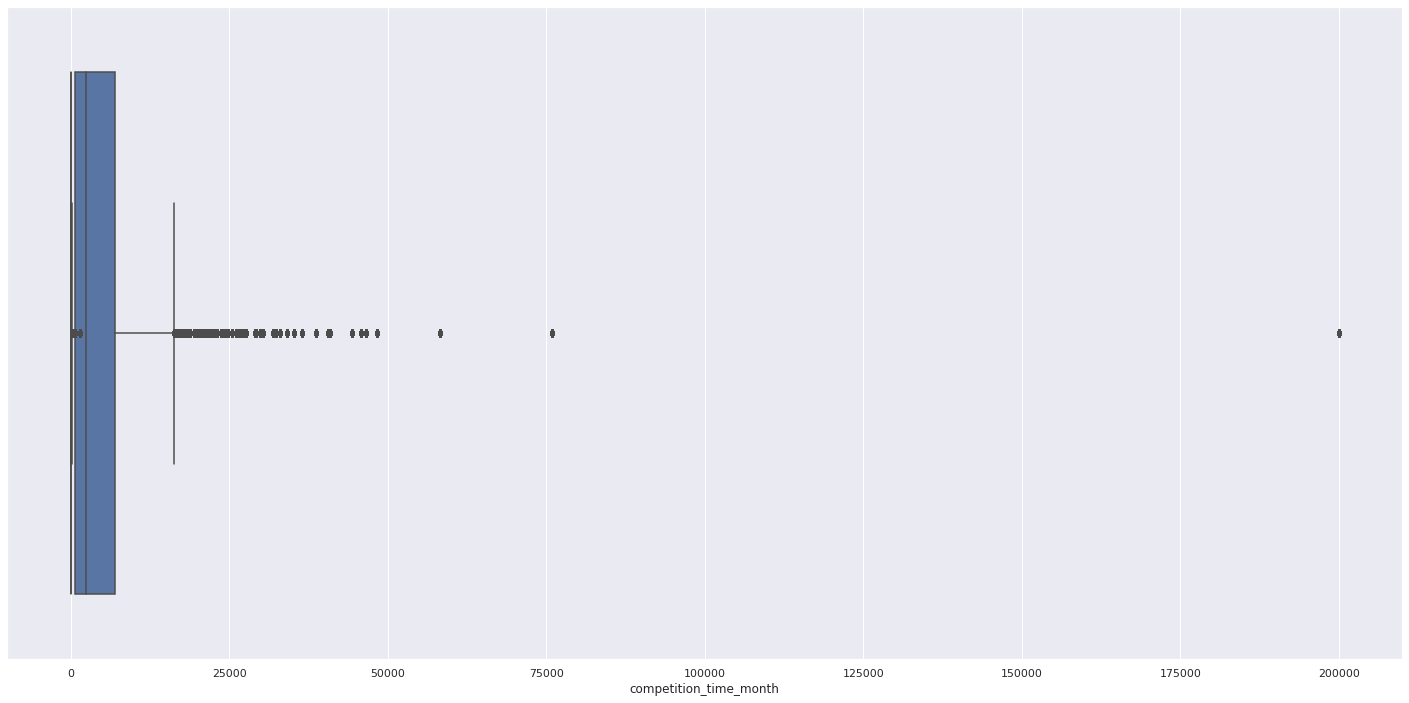

In [55]:
sns.boxplot(df5['competition_distance'])
sns.boxplot(df5['competition_time_month'])

In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)




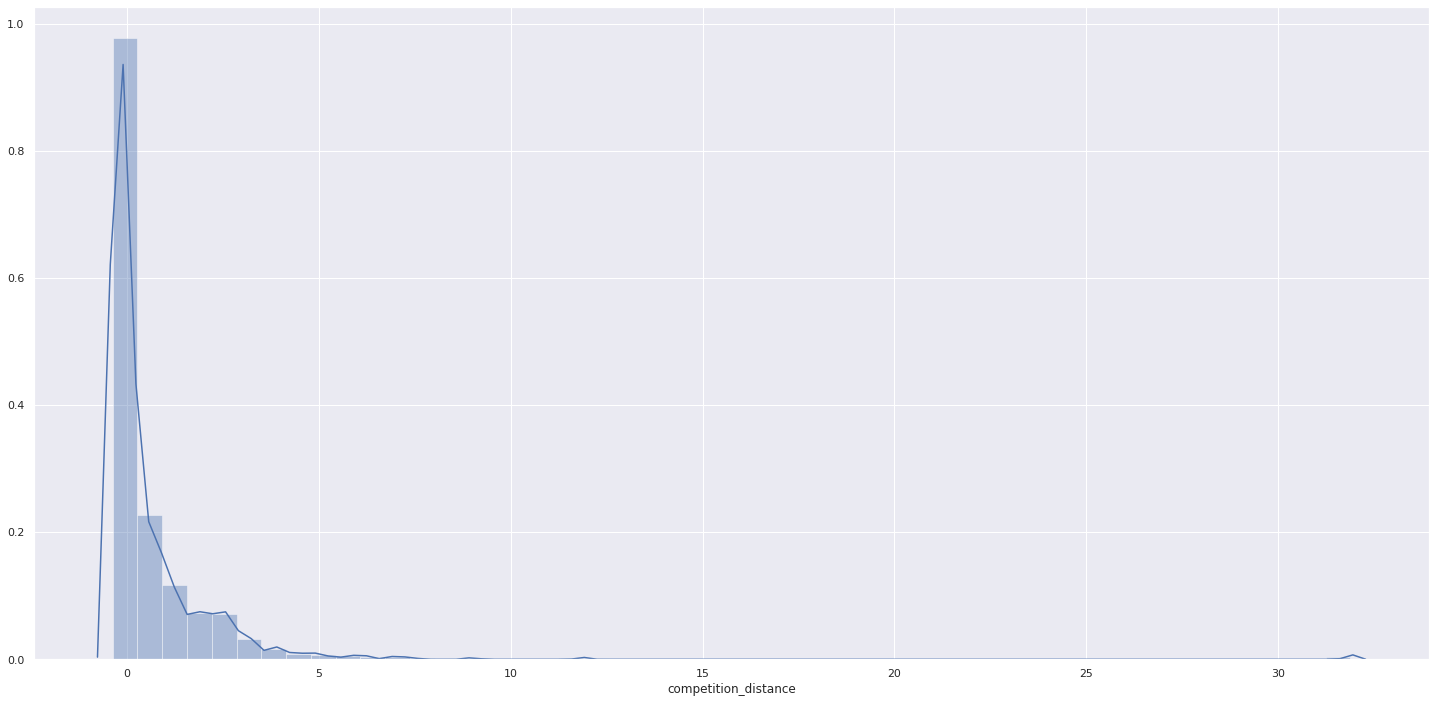

In [57]:
sns.distplot(df5['competition_distance'])

## 5.3. Transformação

### 5.3.1. Encoding

In [58]:
# state holiday - One Hot Encodng
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [59]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,2,-0.275806,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable Transformation

In [60]:
df5['sales'] = np.log1p(df5['sales'])

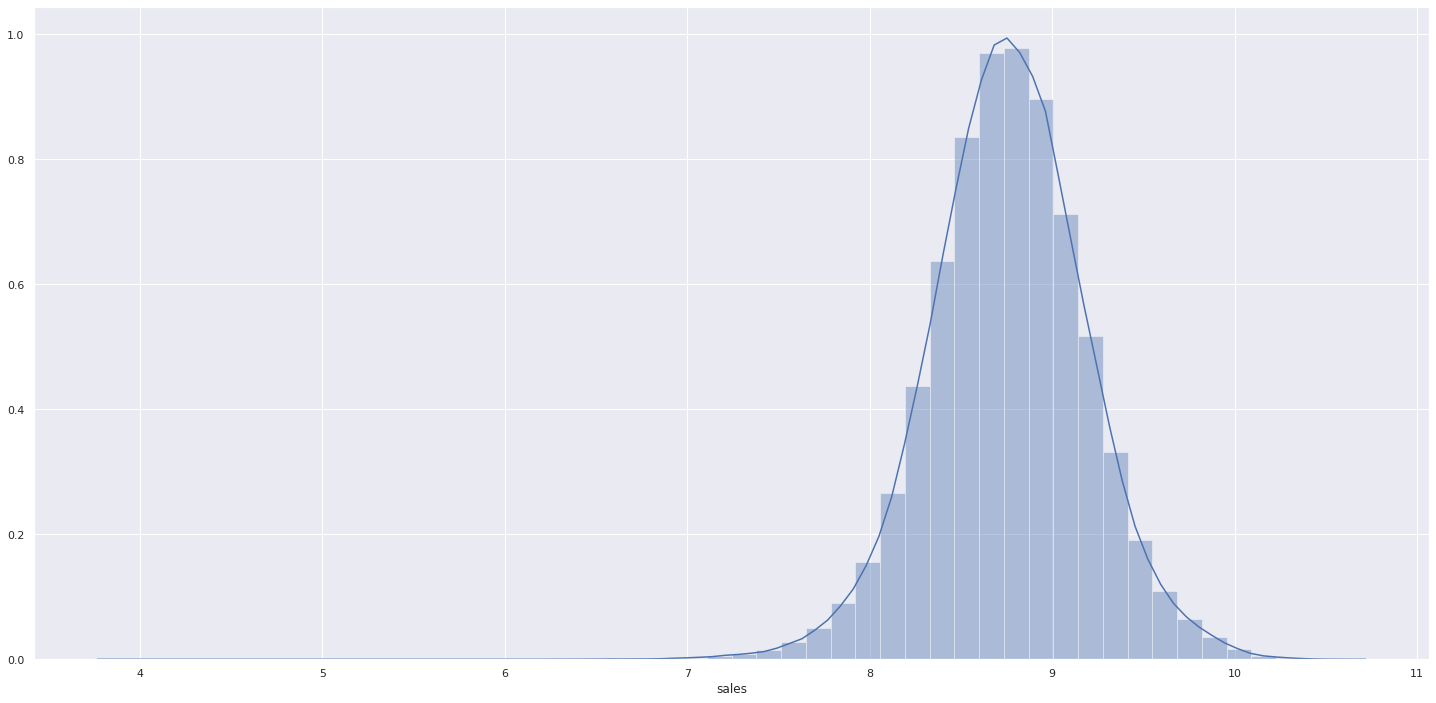

In [61]:
sns.distplot(df5['sales'])

### 5.3.3. Nature Transformation


In [62]:
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

In [63]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.433884,-0.900969,-0.5,-0.866025,0.866025,0.5,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,0.433884,-0.900969,-0.5,-0.866025,0.866025,0.5,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,0.433884,-0.900969,-0.5,-0.866025,0.866025,0.5,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,0.433884,-0.900969,-0.5,-0.866025,0.866025,0.5,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,0.433884,-0.900969,-0.5,-0.866025,0.866025,0.5,-0.568065,-0.822984


# 6.0. Passo 06 - FEATURE SELECTION

In [64]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Training and Test Dataset

In [65]:
# Deletar as variáveis originais que deram origem às variáveis derivadas destas originais

cols_drop = [
    'week_of_year', 'day', 'month', 'day_of_week', 'promo_since',
    'competition_since', 'year_week'
]
df6 = df6.drop(cols_drop, axis=1)

In [66]:
# Últimas 6 semanas como dados de teste, as seis semanas anteriores a este período, dados de treino

df6[[
    'store', 'date'
]].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [67]:
# Dados de treino - Data até 18/06/15
# Dados de teste - Data de 19/06/15 em diante

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [68]:
# # training and test dataset for boruta
# X_train_n = X_train.drop(['date','sales'],axis=1).values
# Y_train_n = Y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=1)

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2,
#                   random_state=42).fit(X_train_n, Y_train_n)

In [69]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs=X_train.drop(['date','sales'],axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# Not Selected Features
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

NameError: name 'boruta' is not defined

## 6.2.3. Manual Feature Selector

In [71]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


# 7.0. Passo 07 - MACHINE LEARNING MODELLING

In [72]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [73]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(
    columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test),
                           np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model


In [74]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1862.727217,0.291638,2661.165949


### 7.2.1 Linear Regression Model - Cross Validation


In [75]:
lr_result_cv = cross_validation(x_training,
                                5,
                                'Linear Regression',
                                lr,
                                verbose=False)
lr_result_cv

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


,model name,MAE CV,MAPE CV,RMSE CV
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",2077.47 +/- 282.24,0.3 +/- 0.02,2941.19 +/- 451.75


,model name,MAE CV,MAPE CV,RMSE CV
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",2077.47 +/- 282.24,0.3 +/- 0.02,2941.19 +/- 451.75


## 7.3. Linear Regression Regularized Model - Lasso


In [76]:
# model
lrr = Lasso(alpha=0.001).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1878.011377,0.288085,2701.215869


### 7.3.1 Lasso - Cross Validation

In [77]:
lrr_result_cv = cross_validation(x_training,
                                5,
                                'Lasso',
                                lrr,
                                verbose=False)
lrr_result_cv

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.80518405714247, tolerance: 11.937395279075515
  model = cd_fast.enet_coordinate_descent(


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


,model name,MAE CV,MAPE CV,RMSE CV
0,"Lasso(alpha=0.001, copy_X=True, fit_intercept=...",2097.25 +/- 318.09,0.3 +/- 0.01,2993.89 +/- 487.89


## 7.4. Random Forest Regressor

In [2]:
# model
rf_init = RandomForestRegressor(n_estimators=100, n_jobs=-1,
                           random_state=42, warm_start=True)

NameError: name 'RandomForestRegressor' is not defined

In [1]:
# model
rf = rf_init.fit(x_train, y_train)

NameError: name 'rf_init' is not defined

In [ ]:
# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test),
                     np.expm1(yhat_rf))

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training,
                                5,
                                'Random Forest Regressor',
                                rf,
                                verbose=False)
rf_result_cv

## 7.5. XGBoost Regressor

In [78]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test),
                      np.expm1(yhat_xgb))
xgb_result

/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,829.9536,0.121138,1223.413345


### 7.5.1.  XGBoost Regressor - Cross Validation


In [79]:
xgb_result_cv = cross_validation(x_training,
                                5,
                                'XGBoost Regressor',
                                model_xgb,
                                verbose=False)
xgb_result_cv

/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/felipe/Repos/Data_Science_Em_Producao/DataSience_Em_Producao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


,model name,MAE CV,MAPE CV,RMSE CV
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",1040.72 +/- 171.81,0.14 +/- 0.01,1509.95 +/- 253.14


## 7.6. Compare Model's Performance

### 7.6.1 Single Performance

In [81]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, xgb_result])
modelling_result.sort_values("RMSE")

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,829.953600,0.121138,1223.413345
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1862.727217,0.291638,2661.165949
0,Linear Regression - Lasso,1878.011377,0.288085,2701.215869


In [82]:
model = LinearRegression()
a = cross_validation(x_training, 5, 'Lasso', model, verbose=False)

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949


In [83]:
a

,model name,MAE CV,MAPE CV,RMSE CV
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",2077.47 +/- 282.24,0.3 +/- 0.02,2941.19 +/- 451.75


### 7.6.2 Real Performance - Cross Validation

In [84]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, xgb_result_cv])
modelling_result_cv

,model name,MAE CV,MAPE CV,RMSE CV
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",2077.47 +/- 282.24,0.3 +/- 0.02,2941.19 +/- 451.75
0,"Lasso(alpha=0.001, copy_X=True, fit_intercept=...",2097.25 +/- 318.09,0.3 +/- 0.01,2993.89 +/- 487.89
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",1040.72 +/- 171.81,0.14 +/- 0.01,1509.95 +/- 253.14


# 8.0. Passo 08 - HYPERPARAMETER FINE TUNING

In [86]:
df8 = df6.copy()

## 8.1. Random Search

In [90]:
import random
import warnings
warnings.filterwarnings('ignore')

In [104]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [105]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):

    # choose values for parameters randomly

    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)

    # model

    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])

    # performance

    result = cross_validation(x_training,
                              2,
                              'XGBoost Regressor',
                              model_xgb,
                              verbose=False)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1862.727217  0.291638  2661.165949
          Model Name          MAE      MAPE         RMSE
0  Linear Regressi

,model name,MAE CV,MAPE CV,RMSE CV
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",1104.96 +/- 91.0,0.15 +/- 0.01,1594.51 +/- 164.7
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",1114.48 +/- 87.5,0.15 +/- 0.01,1617.35 +/- 154.78
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",868.26 +/- 115.0,0.12 +/- 0.01,1264.12 +/- 209.42
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",858.5 +/- 114.25,0.12 +/- 0.01,1240.61 +/- 193.47
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",1093.37 +/- 96.98,0.15 +/- 0.01,1572.89 +/- 181.98


## 8.2. Final Model

In [106]:
param_tuned = {
    'n_estimators': 2500,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.5,
    'colsample_bytree': 0.9,
    'min_child_weight': 15
}

In [107]:
# model

model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance

xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test) , np.expm1(yhat_xgb_tuned))
xgb_result_tuned


final_result

,model name,MAE CV,MAPE CV,RMSE CV
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",1104.96 +/- 91.0,0.15 +/- 0.01,1594.51 +/- 164.7
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",1114.48 +/- 87.5,0.15 +/- 0.01,1617.35 +/- 154.78
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",868.26 +/- 115.0,0.12 +/- 0.01,1264.12 +/- 209.42
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",858.5 +/- 114.25,0.12 +/- 0.01,1240.61 +/- 193.47
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",1093.37 +/- 96.98,0.15 +/- 0.01,1572.89 +/- 181.98


In [111]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.0007780617250086848

# 9.0. Passo 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [112]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['prediction'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [125]:
# sum of predictions
df91 = df9[['store', 'prediction']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[[
    'store', 'sales', 'prediction'
]].groupby('store').apply(lambda x: mean_absolute_error(
    x['sales'], x['prediction'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[[
    'store', 'sales', 'prediction'
]].groupby('store').apply(lambda x: mean_absolute_percentage_error(
    x['sales'], x['prediction'])).reset_index().rename(columns={0: 'MAPE'})

# Merge

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios

df92['worst_scenario'] = df92['prediction'] - df92['MAE']
df92['best_scenario'] = df92['prediction'] + df92['MAE']

# Order columns

df92 = df92[[
    'store', 'prediction', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE'
]]

In [128]:
df92.sort_values("MAPE", ascending=False).head()

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
291,292,105010.593750,101740.065353,108281.122147,3270.528397,0.549363
908,909,234854.000000,227030.644213,242677.355787,7823.355787,0.534665
594,595,339478.468750,334350.508749,344606.428751,5127.960001,0.353765
875,876,203126.921875,198952.511836,207301.331914,4174.410039,0.316907
781,782,221085.546875,220206.276895,221964.816855,879.269980,0.253179


In [126]:
df92.sample(4)

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
847,848,248618.375000,247783.845109,249452.904891,834.529891,0.114479
850,851,200077.500000,199557.435837,200597.564163,520.064163,0.100845
204,205,234188.093750,233628.807459,234747.380041,559.286291,0.086865
1085,1086,223438.953125,222849.736863,224028.169387,589.216262,0.108964


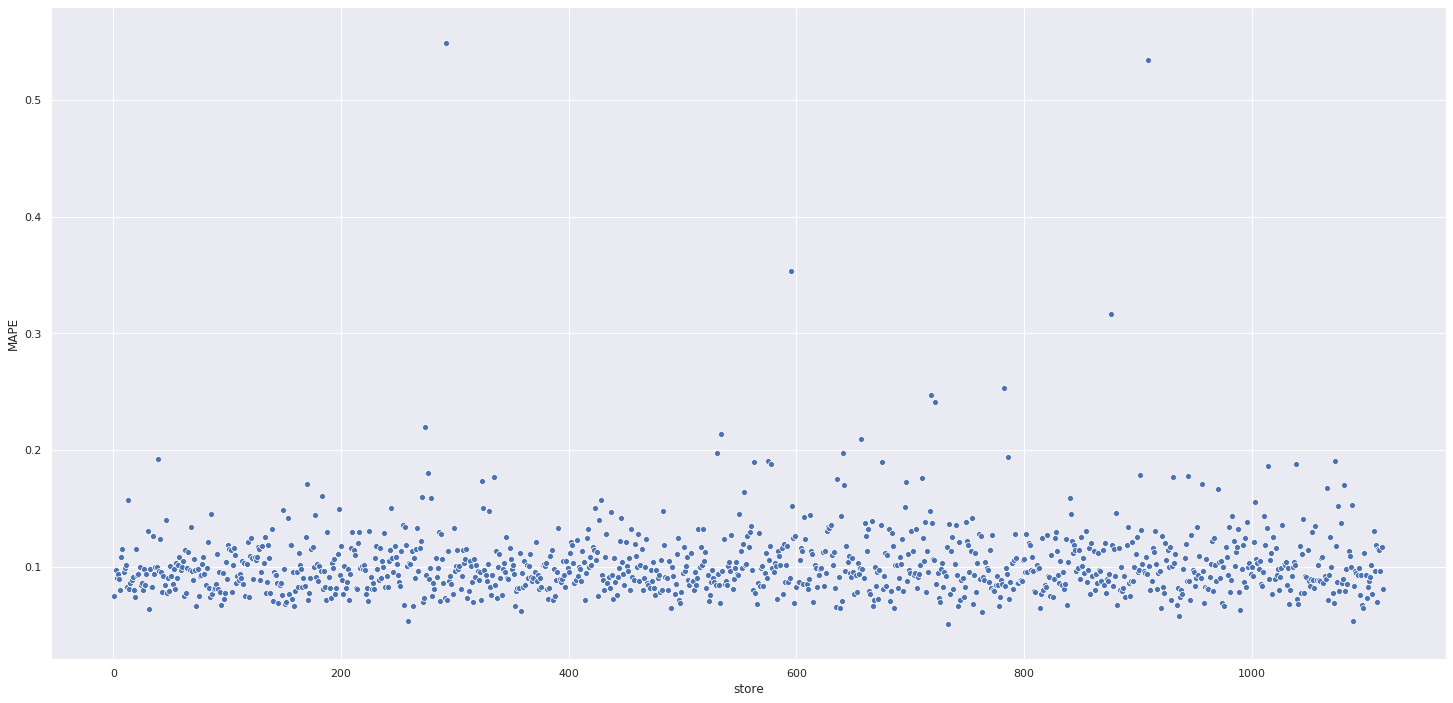

In [130]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [134]:
df93 = df92[['prediction', 'worst_scenario',
      'best_scenario']].apply(lambda x: np.sum(x),
                              axis=0).reset_index().rename(columns={
                                  'index': 'Scenario',
                                  0: 'Values'
                              })

df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,prediction,"R$284,404,546.84"
1,worst_scenario,"R$283,614,035.13"
2,best_scenario,"R$285,195,058.55"


## 9.3. Machine Learning Performance

In [137]:
df9['error'] = df9['sales'] - df9['prediction']
df9['error_rate'] = df9['prediction'] / df9['sales']

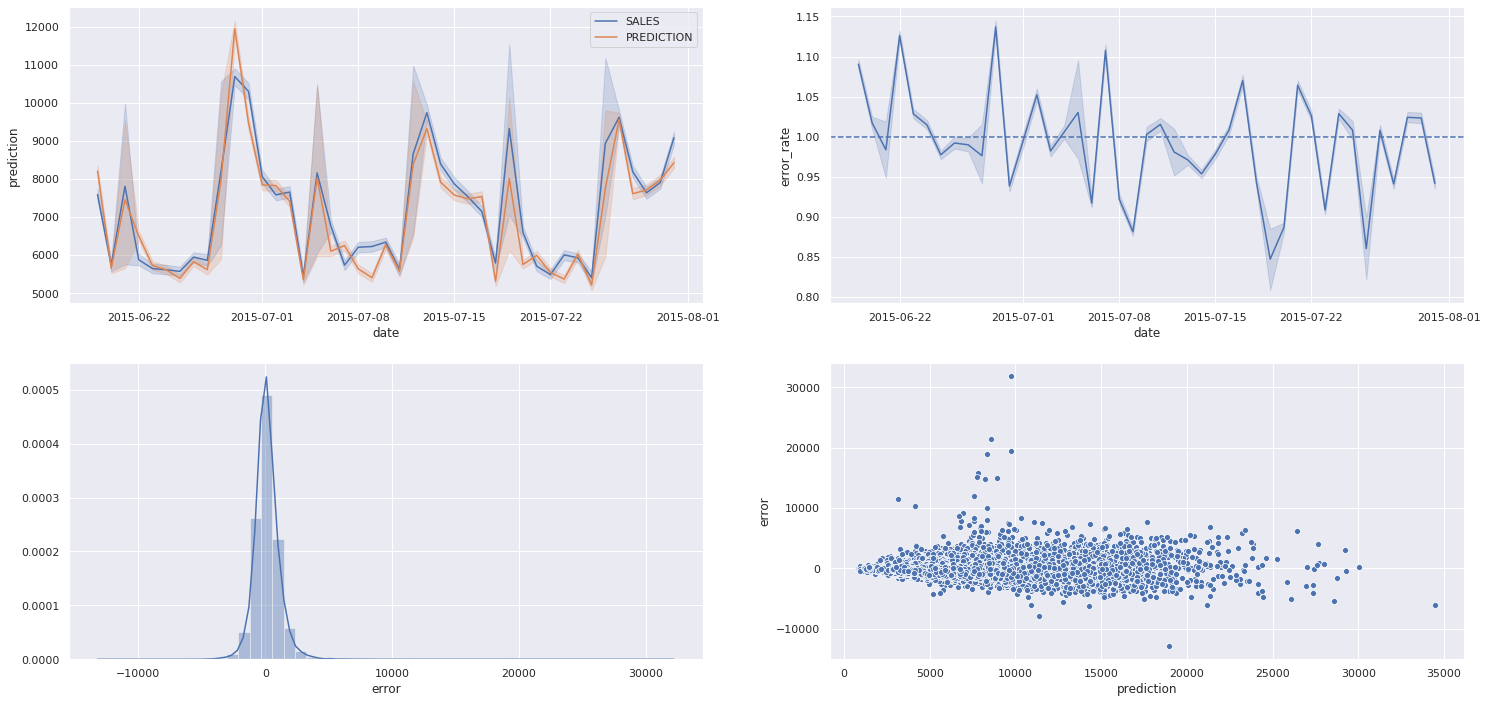

In [139]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='prediction', data=df9, label='PREDICTION')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['prediction'], df9['error'])